# Installing Libraries

In [1]:
!pip install torchmetrics scikit-learn medpy
!pip install monai
!pip install segmentation-models-pytorch
!pip install pretrained-backbones-unet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00


In [2]:
!pip uninstall timm
!pip install timm

Found existing installation: timm 0.6.12
Uninstalling timm-0.6.12:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/timm-0.6.12.dist-info/*
    /usr/local/lib/python3.11/dist-packages/timm/*
Proceed (Y/n)? Y
  Successfully uninstalled timm-0.6.12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pretrained-backbones-unet 0.0.1 requires timm==0.6.12, but you have timm 1.0.14 which is incompatible.


In [3]:
!pip show pretrained-backbones-unet

Name: pretrained-backbones-unet
Version: 0.0.1
Summary: A small example package
Home-page: https://github.com/mberkay0/pretrained-backbones-unet
Author: Berkay Mayali
Author-email: Example Author <author@example.com>
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: timm, torch
Required-by: 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Our imports

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import torchvision.transforms.functional as F
from tqdm import tqdm  # for progress bars
from backbones_unet.model.unet import Unet
# import segmentation_models_pytorch as smp
from torchvision.transforms import InterpolationMode
import random
import matplotlib.pyplot as plt
#cudnn module from PyTorch, which provides access to NVIDIA's CUDA Deep Neural Network library (cuDNN). cuDNN is a library of highly optimized primitives for deep learning.
import torch.backends.cudnn as cudnn
import backbones_unet
from torch.amp import autocast, GradScaler  # Import from torch.amp
from tabulate import tabulate

#Setting Up Reproducibility and CUDA Environment

In [ ]:
# Set seed for reproducibility
SEED = 42
#This line sets the seed for Python's built-in random module.
random.seed(SEED)
#This line sets the seed for NumPy's random number generator.
np.random.seed(SEED)
#This line sets the seed for PyTorch's random number generator for the CPU.
torch.manual_seed(SEED)
if torch.cuda.is_available():
#sets the seed for PyTorch's random number generator for all available GPUs.
    torch.cuda.manual_seed_all(SEED)

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

 # Defines essential parameters for your model training , specifies the locations of your data, determines the size of your datasets, and sets up a location to save your trained model.

In [ ]:
########################################
# Network and Training Parameters      #
########################################
IMG_SIZE = 128
NBEPOCHS = 50
BATCH_SIZE = 16
NBPATIENCE_EPOCHS = 200
NUM_CLASSES = 4 # Assuming 3 classes as confirmed

train_images_path = "/content/drive/MyDrive/✨ GP ✨/CAMUS_PNG/dataset/train/images"
train_masks_path = "/content/drive/MyDrive/✨ GP ✨/CAMUS_PNG/dataset/train/labels"
valid_images_path = "/content/drive/MyDrive/✨ GP ✨/CAMUS_PNG/dataset/valid/images/"
valid_masks_path = "/content/drive/MyDrive/✨ GP ✨/CAMUS_PNG/dataset/valid/labels"
test_images_path = "/content/drive/MyDrive/✨ GP ✨/CAMUS_PNG/dataset/test/images"
test_masks_path = "/content/drive/MyDrive/✨ GP ✨/CAMUS_PNG/dataset/test/labels"

# Function to count the number of files in a directory
def count_files(directory):
    return len([file for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))])

# Print dataset sizes
print("Dataset Sizes:")
print(f"Train Images: {count_files(train_images_path)}")
print(f"Train Masks: {count_files(train_masks_path)}")
print(f"Validation Images: {count_files(valid_images_path)}")
print(f"Validation Masks: {count_files(valid_masks_path)}")
print(f"Test Images: {count_files(test_images_path)}")
print(f"Test Masks: {count_files(test_masks_path)}")

model_path = 'trained_model/'
os.makedirs(model_path, exist_ok=True)


Dataset Sizes:
Train Images: 800
Train Masks: 800
Validation Images: 100
Validation Masks: 100
Test Images: 100
Test Masks: 100


#Custom Dual Transform Class for Image and Mask Augmentation

In [ ]:
#cuDNN will search for the optimal algorithms for your model and hardware during the first few iterations.
cudnn.benchmark = True

class DualTransform:
    def __init__(self, img_size=128, angle=5, translate=(0.05, 0.05), scale=(0.8, 1.2), fill=0, augment=True):
        self.img_size = img_size
        self.angle = angle
        self.translate = translate
        self.scale = scale
        self.fill = fill
        self.augment = augment

    #This method gets called when you apply the DualTransform object to an image-mask pair.
    def __call__(self, image, mask):
      #Resizes both the image and mask to img_size using bilinear and nearest-neighbor interpolation, respectively.
        #Images: Bilinear interpolation for smooth, visually appealing results.
        #Masks: Nearest-neighbor interpolation to preserve sharp class boundaries.
        image = F.resize(image, (self.img_size, self.img_size), interpolation=InterpolationMode.BILINEAR)
        mask = F.resize(mask, (self.img_size, self.img_size), interpolation=InterpolationMode.NEAREST)

        if self.augment:
            angle = random.uniform(-self.angle, self.angle)
            max_dx = self.translate[0] * self.img_size
            max_dy = self.translate[1] * self.img_size
            translations = (random.uniform(-max_dx, max_dx), random.uniform(-max_dy, max_dy))
            scale_factor = random.uniform(self.scale[0], self.scale[1])
            shear = 0.0
            image = F.affine(image, angle=angle, translate=translations, scale=scale_factor, shear=shear, fill=self.fill)
            mask = F.affine(mask, angle=angle, translate=translations, scale=scale_factor, shear=shear, fill=0)
        #Converts the image to a PyTorch tensor using F.to_tensor.
        image = F.to_tensor(image)
        image = F.normalize(image, mean=[0.5], std=[0.5])
        #Converts the mask to a NumPy array and then to a PyTorch tensor.
        mask = np.array(mask, dtype=np.int64)
        mask = torch.from_numpy(mask)
        mask = self.remap_mask(mask)
        return image, mask

    @staticmethod
    #This method remaps the mask values to specific class labels
    def remap_mask(mask):
        remapped = torch.zeros_like(mask)
        remapped[mask == 0] = 0 #bg
        remapped[mask == 85] = 1 #lv
        remapped[mask == 170] = 2 #myo
        remapped[mask == 255] = 3 #la
        return remapped

# Custom Dataset Class for CAMUS Data
 the `CAMUSDataset` class does the following:
1. ***Initialization***:
It takes the directories for images and masks and an optional transform.
It loads the filenames of images and masks, and ensures there's an equal number of both.
2. `__len__:` Returns the total number of samples (images) in the dataset.
3. `__getitem__:` This is the core method that gets called when you access a specific item in the dataset using an index (idx). It:

* Loads the image and mask using the index.
* Applies the provided transform (if any) to both image and mask.
* Return image, mask, and image filename


In [ ]:
########################################
# Dataset                              #
########################################

class CAMUSDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
        assert len(self.images) == len(self.masks), "Number of images and masks must be the same."

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path)

        if self.transform:
            image, mask = self.transform(image, mask)

        # Return image, mask, and image filename
        return image, mask, self.images[idx]


* ` num_workers=2:` Uses 2 worker processes to load data in parallel, which can speed up data loading.
* ` pin_memory=True:` Copies tensors into CUDA pinned memory before returning them, which can improve performance when transferring data to the GPU.

In [ ]:
########################################
# Dataloaders                          #
########################################
train_transform = DualTransform(img_size=IMG_SIZE, angle=5, translate=(0.05,0.05), scale=(0.8,1.2), augment=True) #False as the paper
valid_transform = DualTransform(img_size=IMG_SIZE, angle=0, translate=(0,0), scale=(1,1), augment=False)
test_transform = DualTransform(img_size=IMG_SIZE, angle=0, translate=(0,0), scale=(1,1), augment=False)

train_dataset = CAMUSDataset(train_images_path, train_masks_path, transform=train_transform)
valid_dataset = CAMUSDataset(valid_images_path, valid_masks_path, transform=valid_transform)
test_dataset = CAMUSDataset(test_images_path, test_masks_path, transform=test_transform)

#DataLoader takes a dataset object and provides an iterable over the data, allowing you to efficiently load batches of data during training and evaluation.
# Reduce number of workers as suggested
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

##  Display the augmented images


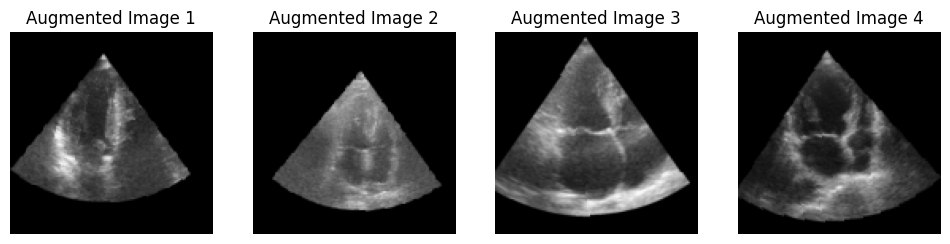

In [ ]:
# Create a sample dataset and loader
sample_dataset = CAMUSDataset(train_images_path, train_masks_path, transform=train_transform)
sample_loader = DataLoader(sample_dataset, batch_size=4, shuffle=True)  # Adjust batch_size as needed

# Get a batch of augmented images and masks
images, masks, filenames = next(iter(sample_loader))

# Display the augmented images
fig, axs = plt.subplots(1, 4, figsize=(12, 3))  # Adjust figure size as needed

for i in range(4):  # Assuming batch_size of 4
    # Denormalize the image
    image = images[i].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5
    axs[i].imshow(image)
    axs[i].set_title(f"Augmented Image {i + 1}")
    axs[i].axis("off")

plt.show()

# Model Initialization  

In [ ]:

print(backbones_unet.__available_models__)

['convnext_atto', 'convnext_atto_ols', 'convnext_base', 'convnext_base_384_in22ft1k', 'convnext_base_in22ft1k', 'convnext_base_in22k', 'convnext_femto', 'convnext_femto_ols', 'convnext_large', 'convnext_large_384_in22ft1k', 'convnext_large_in22ft1k', 'convnext_large_in22k', 'convnext_nano', 'convnext_nano_ols', 'convnext_pico', 'convnext_pico_ols', 'convnext_small', 'convnext_small_384_in22ft1k', 'convnext_small_in22ft1k', 'convnext_small_in22k', 'convnext_tiny', 'convnext_tiny_384_in22ft1k', 'convnext_tiny_hnf', 'convnext_tiny_in22ft1k', 'convnext_tiny_in22k', 'convnext_xlarge_384_in22ft1k', 'convnext_xlarge_in22ft1k', 'convnext_xlarge_in22k', 'cs3darknet_focus_l', 'cs3darknet_focus_m', 'cs3darknet_l', 'cs3darknet_m', 'cs3darknet_x', 'cs3edgenet_x', 'cs3se_edgenet_x', 'cs3sedarknet_l', 'cs3sedarknet_x', 'cspdarknet53', 'cspresnet50', 'cspresnext50', 'darknet53', 'darknetaa53', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'densenetblur121d', 'dm_nfnet_f0', 'dm_nfnet_f1',

In [6]:
########################################
# Model Initialization                 #
########################################
# model = smp.Unet(
#     encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=NUM_CLASSES,                      # model output channels (number of classes in your dataset)
# )

model = Unet(
    backbone='convnext_tiny',
    in_channels=3,
    num_classes=NUM_CLASSES
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

#Multi-Class Dice Loss and IoU Calculation

In [ ]:
# Custom MultiClassDiceLoss
class MultiClassDiceLoss(nn.Module):
    def __init__(self, from_logits=True, eps=1e-6):
        """
        Initialize the MultiClassDiceLoss.

        Args:
            from_logits (bool): If True, applies softmax to predictions first
            Logits are the raw output values from the final layer of a neural network before any activation function (like softmax) is applied. They're essentially the unnormalized predictions.
            eps (float): Small constant to avoid division by zero
        """
        super().__init__()  # Initialize parent class (nn.Module)
        self.from_logits = from_logits  # Whether input is raw logits
        self.eps = eps  # Small epsilon to prevent division by zero

    def forward(self, y_pred, y_true):
        """
        Compute the multi-class Dice loss.

        Args:
            y_pred: Model predictions (B, C, H, W)
            Variables:
              B: Batch size - The number of samples in the batch.
              C: Number of channels - In semantic segmentation, this usually corresponds to the number of classes.
              H: Height of the feature maps/images.
              W: Width of the feature maps/images.
            y_true: Ground truth labels (B, H, W) with class indices
        """
        # If predictions are logits, convert to probabilities
        if self.from_logits:
            y_pred = torch.softmax(y_pred, dim=1)  # Apply softmax along channel dimension

        B, C, H, W = y_pred.shape  # Get dimensions of prediction tensor
        dice_loss = 0.0  # Initialize total loss

        # Iterate over each class
        for c in range(C):
            # Convert ground truth to one-hot for current class
            y_true_c = (y_true == c).float()  # Binary mask for class c

            # Get predictions for current class
            y_pred_c = y_pred[:, c, :, :]  # Probability map for class c

            # Calculate intersection (TP)
            intersection = (y_pred_c * y_true_c).sum(dim=(1,2))

            # Calculate union (total area)
            union = y_pred_c.sum(dim=(1,2)) + y_true_c.sum(dim=(1,2))

            # Calculate Dice coefficient for current class
            dice_c = (2.0 * intersection + self.eps) / (union + self.eps)

            # Add (1 - dice) to total loss
            dice_loss += (1 - dice_c.mean())

        # Return average loss across all classes
        return dice_loss / C

# Example usage and parameter descriptions:

# For MultiClassDiceLoss:
criterion = MultiClassDiceLoss(
    from_logits=True,  # Set True if model outputs raw logits
    eps=1e-6  # Small constant for numerical stability
)

In [ ]:
# Manual IoU Implementation
def compute_iou_manual(pred, target, num_classes=NUM_CLASSES):
    """
    Manually compute IoU (Intersection over Union) for semantic segmentation.

    Args:
        pred (torch.Tensor): Predicted segmentation mask
        target (torch.Tensor): Ground truth segmentation mask
        num_classes (int): Number of classes in the segmentation task

    Returns:
        float: Mean IoU across all classes
    """
    ious = []  # Store IoU for each class
    for c in range(num_classes):
        # Create binary masks for current class
        pred_c = (pred == c)  # Prediction mask for class c
        target_c = (target == c)  # Ground truth mask for class c

        # Calculate intersection and union
        intersection = (pred_c & target_c).sum().item()  # Logical AND for intersection
        union = (pred_c | target_c).sum().item()  # Logical OR for union

        # Calculate IoU if union is non-zero
        if union > 0:
            ious.append(intersection / (union + 1e-6))  # Add small epsilon to prevent division by zero

    # Handle edge case where no valid classes are found
    if len(ious) == 0:
        return 1.0

    # Return mean IoU across all valid classes
    return sum(ious) / len(ious)






#  Training and Validation Workflow for Semantic Segmentation

In [ ]:

########################################
# Training & Validation Functions      #
########################################


def train(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0.0
    epoch_iou = 0.0
    scaler = GradScaler()

    with tqdm(total=len(loader), desc='Training') as pbar:
        for images, masks, _ in loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            preds = torch.argmax(outputs, dim=1)
            batch_iou = compute_iou_manual(preds, masks, num_classes=NUM_CLASSES)

            epoch_loss += loss.item()
            epoch_iou += batch_iou
            pbar.update(1)

    return epoch_loss / len(loader), epoch_iou / len(loader)

In [ ]:
def validate(model, loader, criterion, device):
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
        with tqdm(total=len(loader), desc='Validation') as pbar:
            for images, masks, _ in loader:
                images, masks = images.to(device), masks.to(device)
                with torch.amp.autocast(device_type='cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                preds = torch.argmax(outputs, dim=1)
                batch_iou = compute_iou_manual(preds, masks, num_classes=NUM_CLASSES)
                val_loss += loss.item()
                val_iou += batch_iou
                pbar.update(1)

    return val_loss / len(loader), val_iou / len(loader)



---

# Training Loop




Epoch 1/50


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


Train Loss: 0.7013, Train Dice: 0.4990
Val Loss: 0.5748, Val Dice: 0.6959
Model saved!


<ipython-input-34-bef1d7dd5254>:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth")))


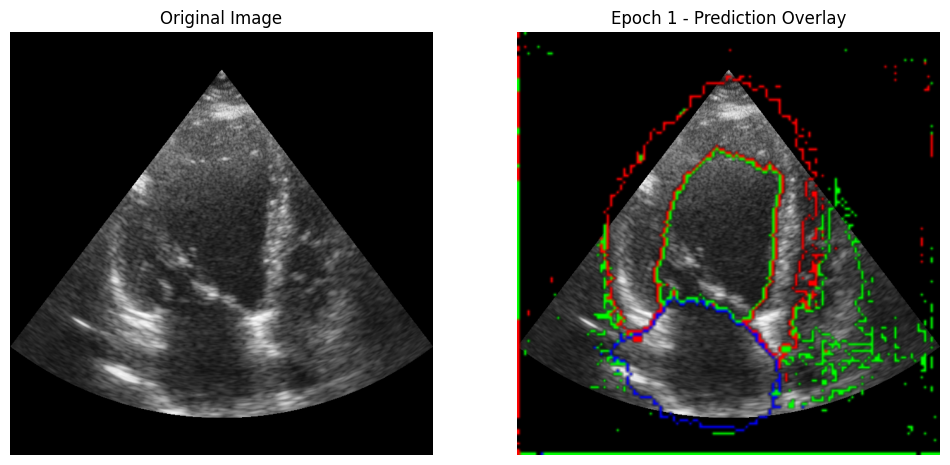

Epoch 2/50


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Train Loss: 0.5384, Train Dice: 0.7459
Val Loss: 0.4499, Val Dice: 0.8253
Model saved!


<Figure size 640x480 with 0 Axes>

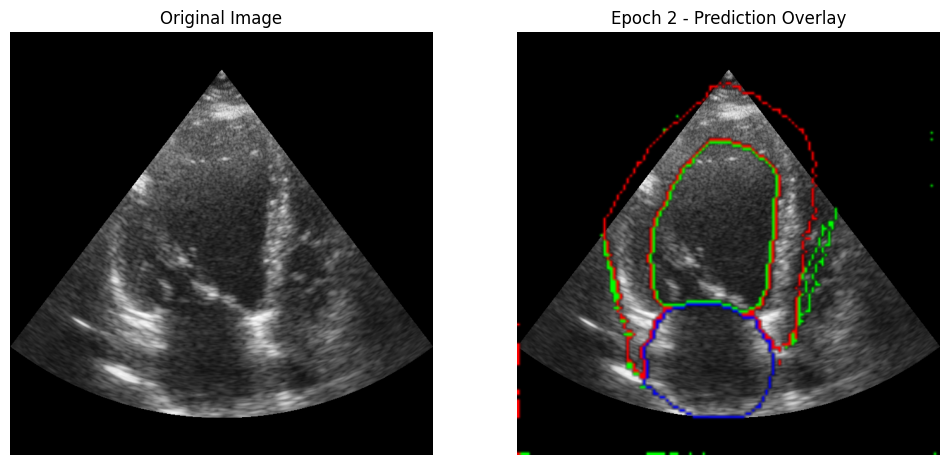

Epoch 3/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.05it/s]


Train Loss: 0.4279, Train Dice: 0.8378
Val Loss: 0.3667, Val Dice: 0.8719
Model saved!


<Figure size 640x480 with 0 Axes>

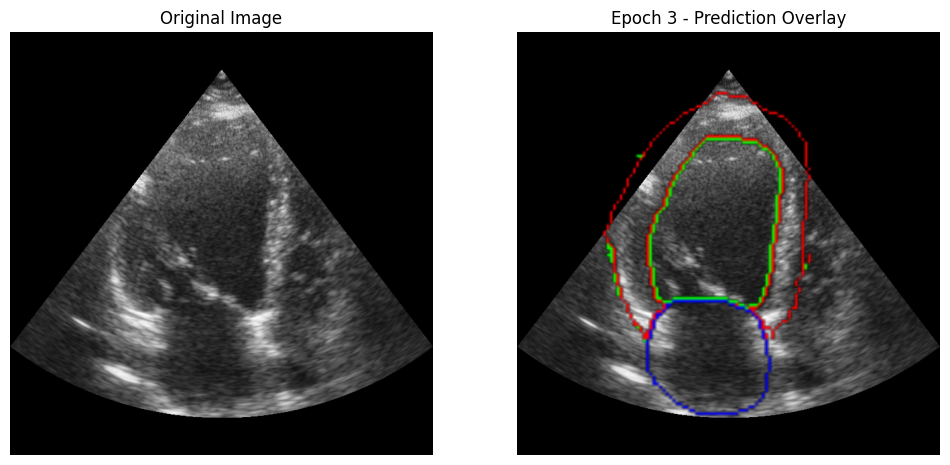

Epoch 4/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.57it/s]


Train Loss: 0.3267, Train Dice: 0.8815
Val Loss: 0.2784, Val Dice: 0.8966
Model saved!


<Figure size 640x480 with 0 Axes>

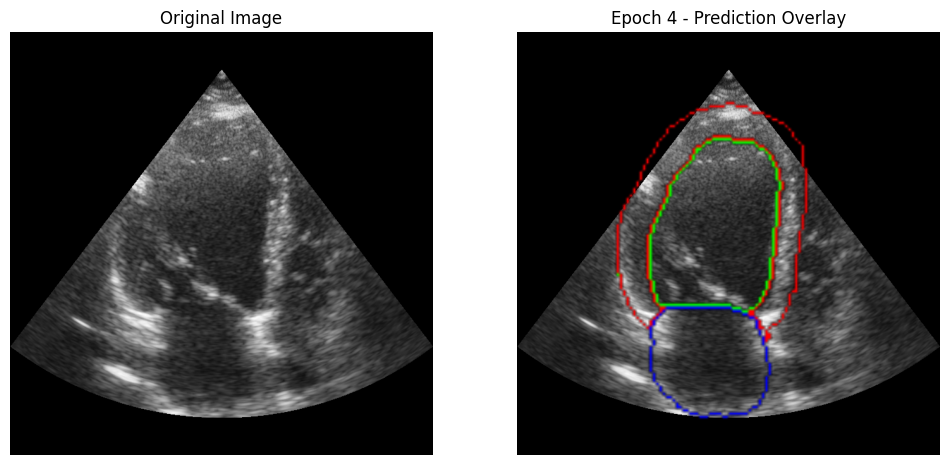

Epoch 5/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.34it/s]


Train Loss: 0.2489, Train Dice: 0.9006
Val Loss: 0.2130, Val Dice: 0.9085
Model saved!


<Figure size 640x480 with 0 Axes>

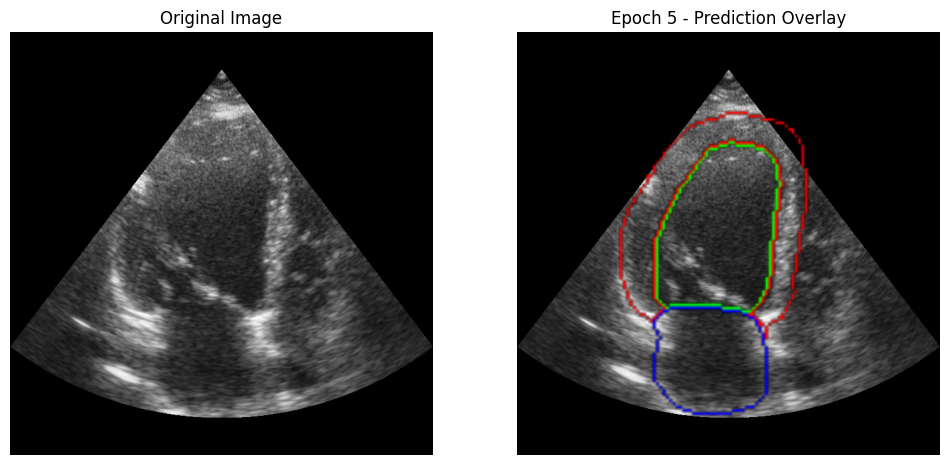

Epoch 6/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.49it/s]


Train Loss: 0.1931, Train Dice: 0.9140
Val Loss: 0.1693, Val Dice: 0.9171
Model saved!


<Figure size 640x480 with 0 Axes>

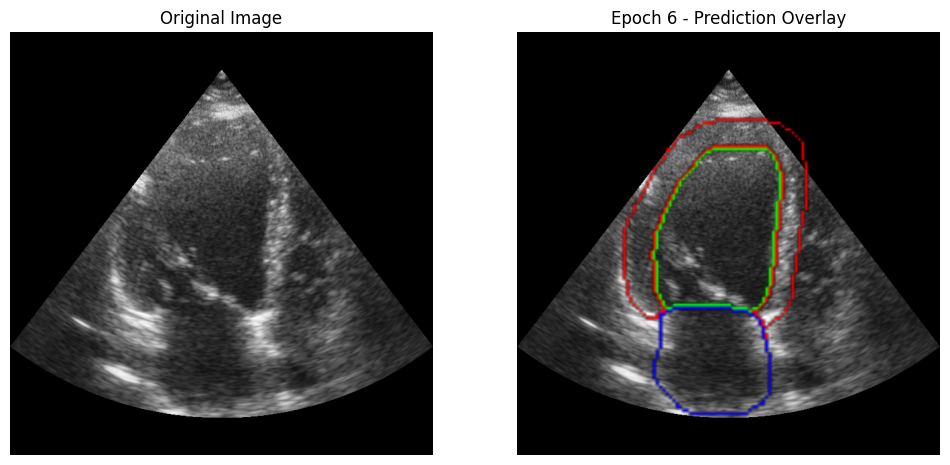

Epoch 7/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Train Loss: 0.1586, Train Dice: 0.9211
Val Loss: 0.1472, Val Dice: 0.9166
Model saved!


<Figure size 640x480 with 0 Axes>

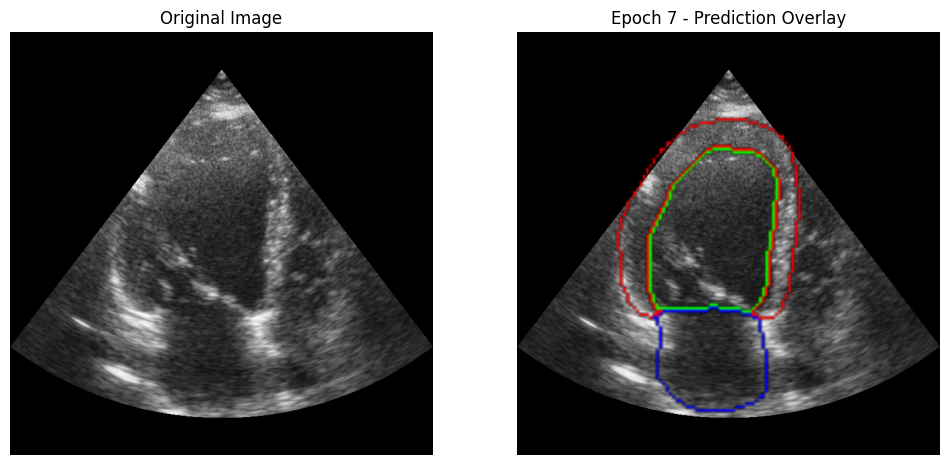

Epoch 8/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.16it/s]


Train Loss: 0.1403, Train Dice: 0.9213
Val Loss: 0.1323, Val Dice: 0.9194
Model saved!


<Figure size 640x480 with 0 Axes>

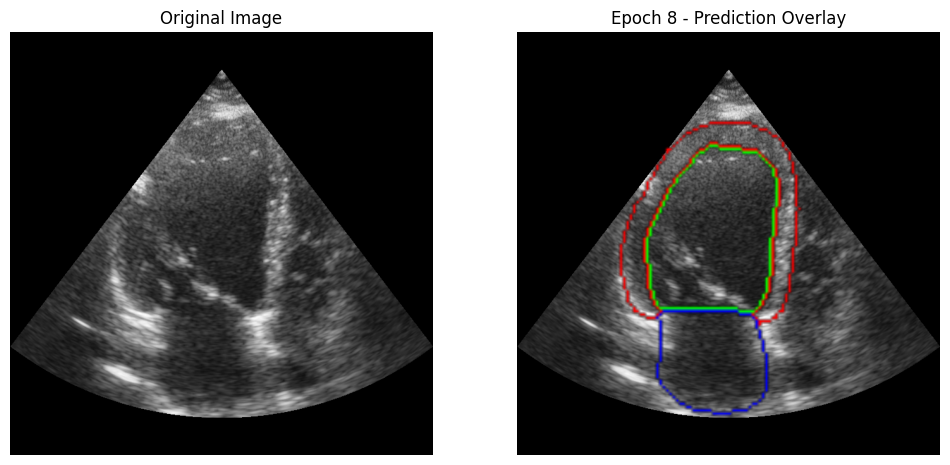

Epoch 9/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.05it/s]


Train Loss: 0.1223, Train Dice: 0.9266
Val Loss: 0.1206, Val Dice: 0.9209
Model saved!


<Figure size 640x480 with 0 Axes>

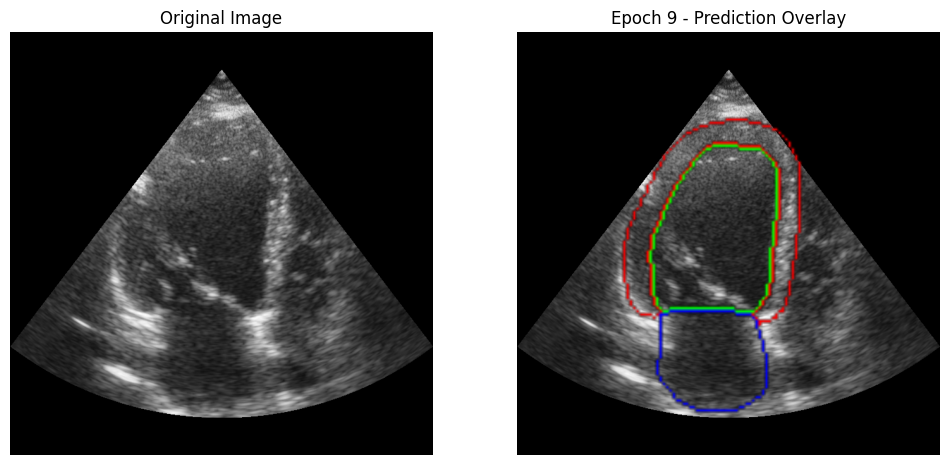

Epoch 10/50


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


Train Loss: 0.1094, Train Dice: 0.9315
Val Loss: 0.1083, Val Dice: 0.9259
Model saved!


<Figure size 640x480 with 0 Axes>

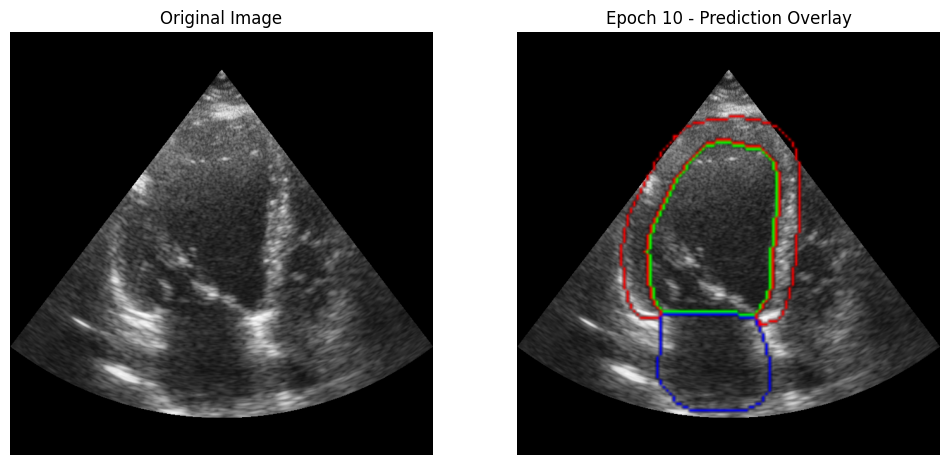

Epoch 11/50


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Train Loss: 0.1030, Train Dice: 0.9319
Val Loss: 0.1053, Val Dice: 0.9237
Model saved!


<Figure size 640x480 with 0 Axes>

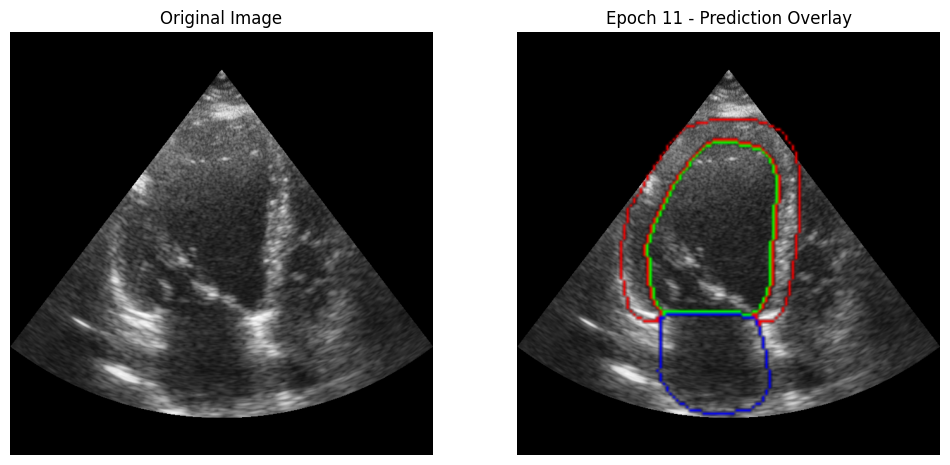

Epoch 12/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]


Train Loss: 0.0974, Train Dice: 0.9333
Val Loss: 0.0999, Val Dice: 0.9249
Model saved!


<Figure size 640x480 with 0 Axes>

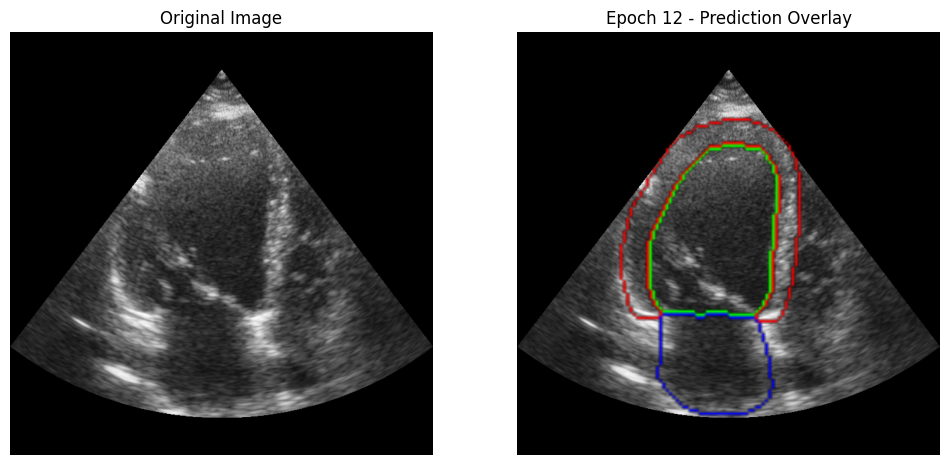

Epoch 13/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.18it/s]


Train Loss: 0.0918, Train Dice: 0.9350
Val Loss: 0.1038, Val Dice: 0.9178
Epoch 14/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Train Loss: 0.0858, Train Dice: 0.9377
Val Loss: 0.0970, Val Dice: 0.9224
Model saved!


<Figure size 640x480 with 0 Axes>

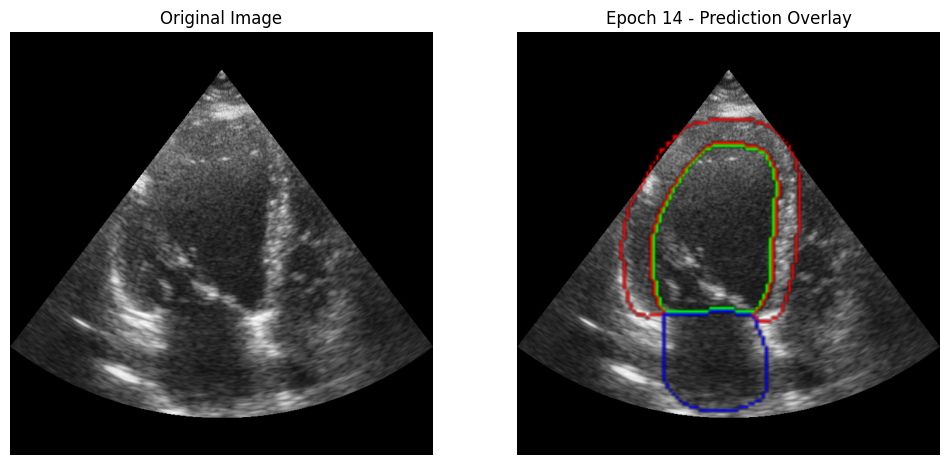

Epoch 15/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.09it/s]


Train Loss: 0.0815, Train Dice: 0.9403
Val Loss: 0.0929, Val Dice: 0.9246
Model saved!


<Figure size 640x480 with 0 Axes>

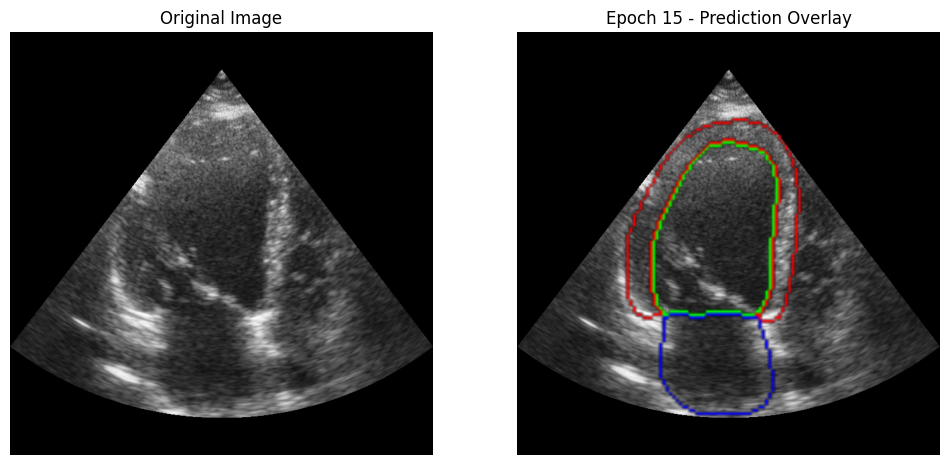

Epoch 16/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.31it/s]


Train Loss: 0.0786, Train Dice: 0.9411
Val Loss: 0.0906, Val Dice: 0.9246
Model saved!


<Figure size 640x480 with 0 Axes>

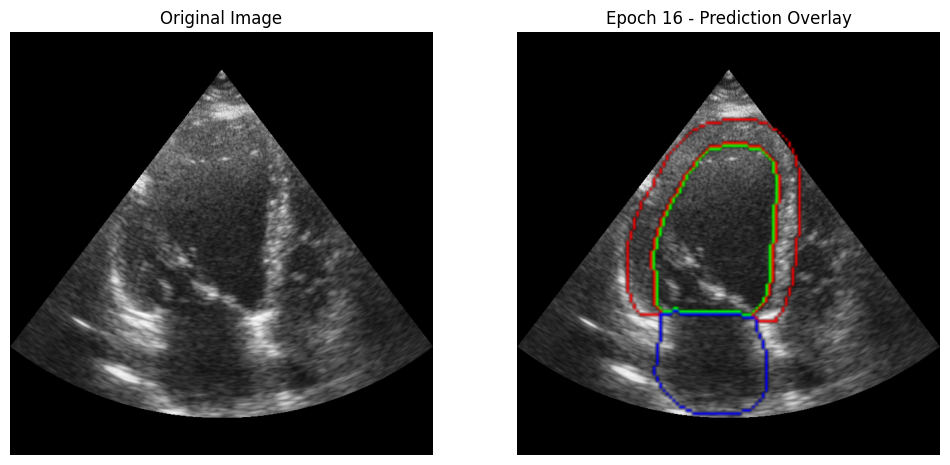

Epoch 17/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.85it/s]


Train Loss: 0.0754, Train Dice: 0.9420
Val Loss: 0.0862, Val Dice: 0.9285
Model saved!


<Figure size 640x480 with 0 Axes>

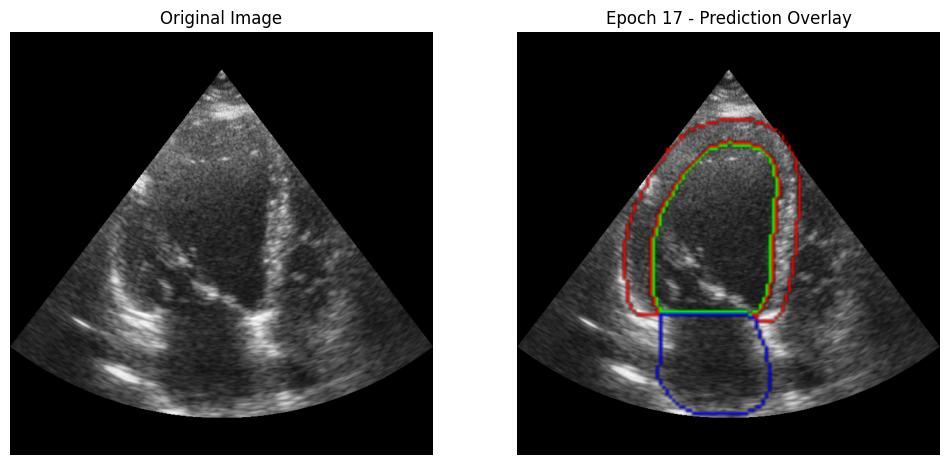

Epoch 18/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.16it/s]


Train Loss: 0.0740, Train Dice: 0.9426
Val Loss: 0.0888, Val Dice: 0.9246
Epoch 19/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.17it/s]


Train Loss: 0.0720, Train Dice: 0.9434
Val Loss: 0.0853, Val Dice: 0.9280
Model saved!


<Figure size 640x480 with 0 Axes>

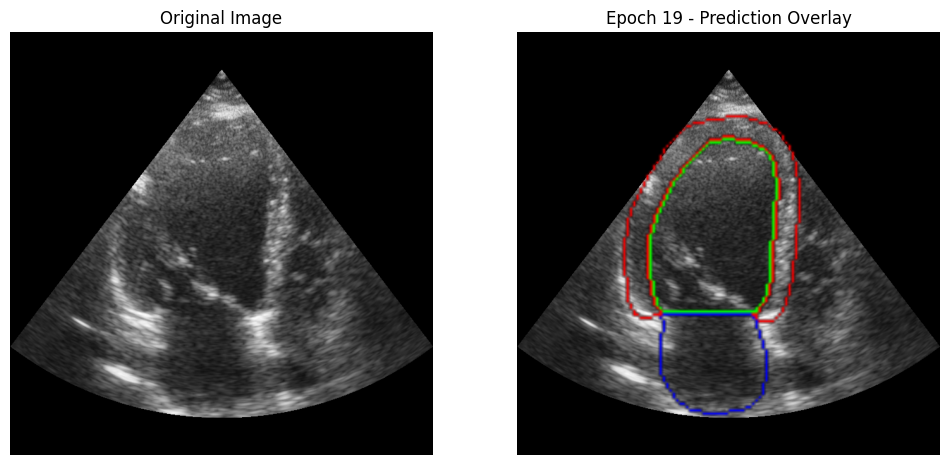

Epoch 20/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]


Train Loss: 0.0696, Train Dice: 0.9455
Val Loss: 0.0896, Val Dice: 0.9236
Epoch 21/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.97it/s]


Train Loss: 0.0689, Train Dice: 0.9449
Val Loss: 0.0850, Val Dice: 0.9265
Model saved!


<Figure size 640x480 with 0 Axes>

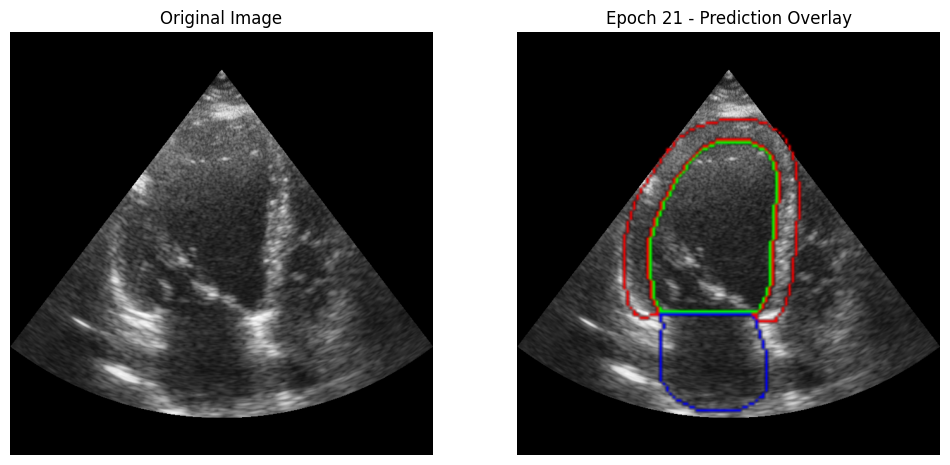

Epoch 22/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.56it/s]


Train Loss: 0.0688, Train Dice: 0.9450
Val Loss: 0.0872, Val Dice: 0.9251
Epoch 23/50


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


Train Loss: 0.0648, Train Dice: 0.9476
Val Loss: 0.0807, Val Dice: 0.9299
Model saved!


<Figure size 640x480 with 0 Axes>

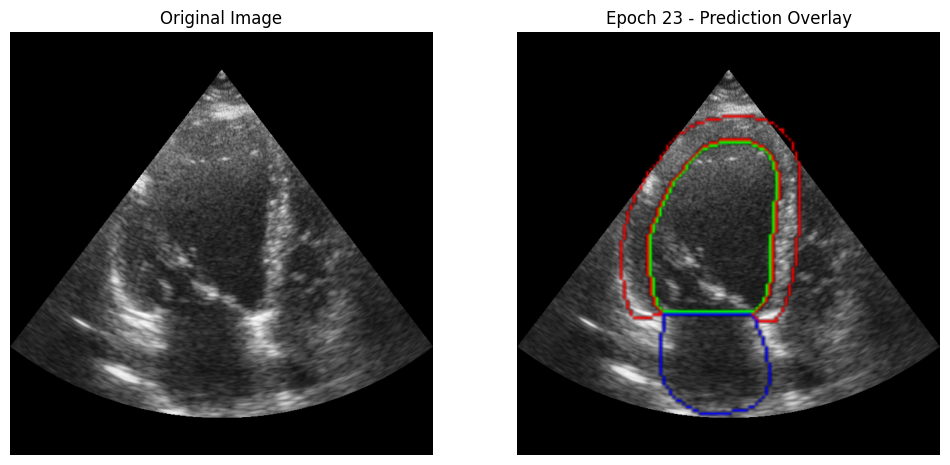

Epoch 24/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


Train Loss: 0.0641, Train Dice: 0.9478
Val Loss: 0.0859, Val Dice: 0.9247
Epoch 25/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.24it/s]


Train Loss: 0.0625, Train Dice: 0.9485
Val Loss: 0.0826, Val Dice: 0.9277
Epoch 26/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.96it/s]


Train Loss: 0.0604, Train Dice: 0.9505
Val Loss: 0.0839, Val Dice: 0.9256
Epoch 27/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.15it/s]


Train Loss: 0.0590, Train Dice: 0.9513
Val Loss: 0.0853, Val Dice: 0.9236
Epoch 28/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.00it/s]


Train Loss: 0.0581, Train Dice: 0.9522
Val Loss: 0.0783, Val Dice: 0.9301
Model saved!


<Figure size 640x480 with 0 Axes>

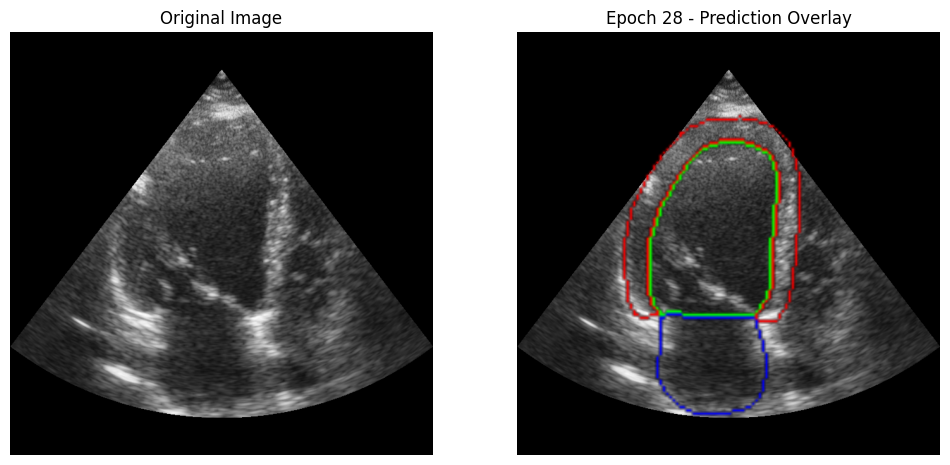

Epoch 29/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.01it/s]


Train Loss: 0.0581, Train Dice: 0.9516
Val Loss: 0.0881, Val Dice: 0.9214
Epoch 30/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.68it/s]


Train Loss: 0.0562, Train Dice: 0.9528
Val Loss: 0.0797, Val Dice: 0.9288
Epoch 31/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.20it/s]


Train Loss: 0.0555, Train Dice: 0.9532
Val Loss: 0.0781, Val Dice: 0.9299
Model saved!


<Figure size 640x480 with 0 Axes>

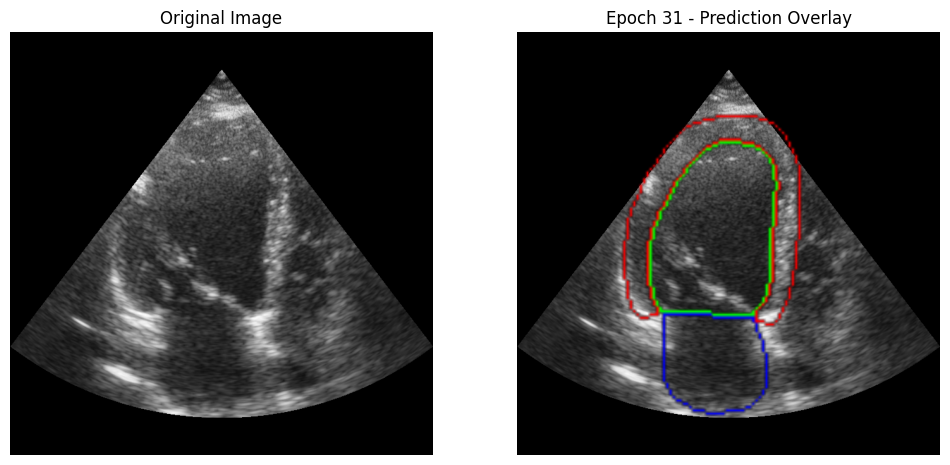

Epoch 32/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.00it/s]


Train Loss: 0.0548, Train Dice: 0.9539
Val Loss: 0.0808, Val Dice: 0.9271
Epoch 33/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.01it/s]


Train Loss: 0.0544, Train Dice: 0.9539
Val Loss: 0.0809, Val Dice: 0.9267
Epoch 34/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.97it/s]


Train Loss: 0.0535, Train Dice: 0.9549
Val Loss: 0.0800, Val Dice: 0.9274
Epoch 35/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.77it/s]


Train Loss: 0.0519, Train Dice: 0.9561
Val Loss: 0.0814, Val Dice: 0.9260
Epoch 36/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.01it/s]


Train Loss: 0.0527, Train Dice: 0.9549
Val Loss: 0.0831, Val Dice: 0.9242
Epoch 37/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.99it/s]


Train Loss: 0.0515, Train Dice: 0.9560
Val Loss: 0.0796, Val Dice: 0.9276
Epoch 38/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.17it/s]


Train Loss: 0.0514, Train Dice: 0.9558
Val Loss: 0.0769, Val Dice: 0.9301
Model saved!


<Figure size 640x480 with 0 Axes>

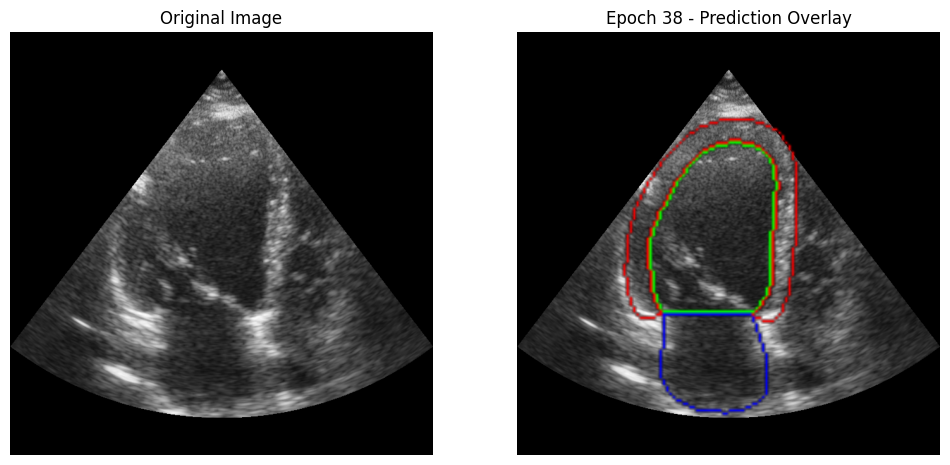

Epoch 39/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]


Train Loss: 0.0491, Train Dice: 0.9580
Val Loss: 0.0775, Val Dice: 0.9292
Epoch 40/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]


Train Loss: 0.0490, Train Dice: 0.9579
Val Loss: 0.0807, Val Dice: 0.9261
Epoch 41/50


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Train Loss: 0.0484, Train Dice: 0.9585
Val Loss: 0.0763, Val Dice: 0.9301
Model saved!


<Figure size 640x480 with 0 Axes>

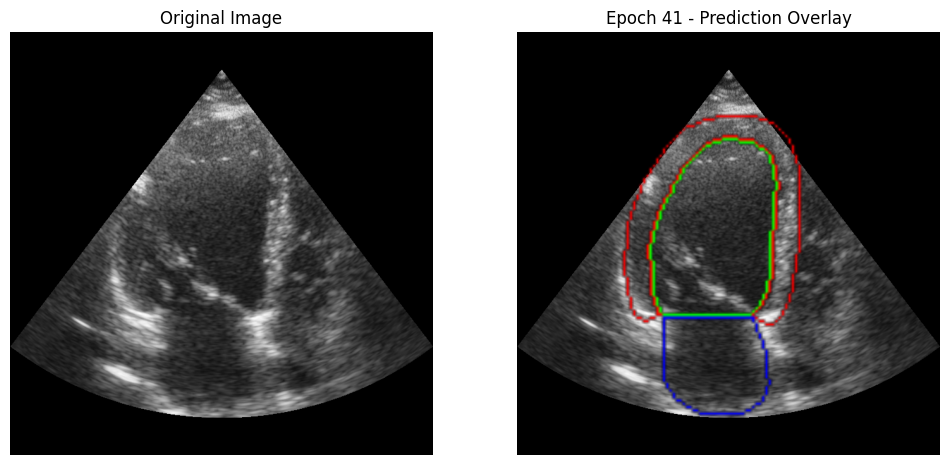

Epoch 42/50


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Train Loss: 0.0480, Train Dice: 0.9584
Val Loss: 0.0765, Val Dice: 0.9305
Epoch 43/50


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Train Loss: 0.0480, Train Dice: 0.9588
Val Loss: 0.0758, Val Dice: 0.9306
Model saved!


<Figure size 640x480 with 0 Axes>

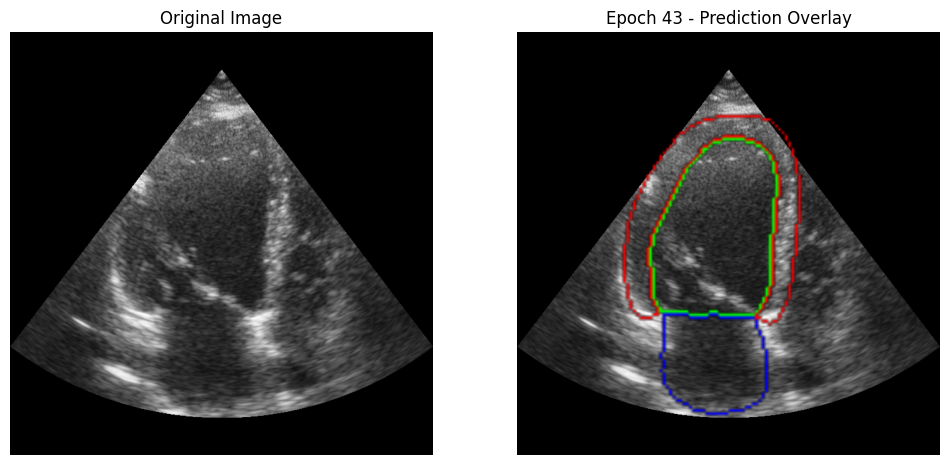

Epoch 44/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.82it/s]


Train Loss: 0.0473, Train Dice: 0.9591
Val Loss: 0.0792, Val Dice: 0.9263
Epoch 45/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.03it/s]


Train Loss: 0.0455, Train Dice: 0.9605
Val Loss: 0.0769, Val Dice: 0.9291
Epoch 46/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.75it/s]


Train Loss: 0.0460, Train Dice: 0.9601
Val Loss: 0.0756, Val Dice: 0.9306
Model saved!


<Figure size 640x480 with 0 Axes>

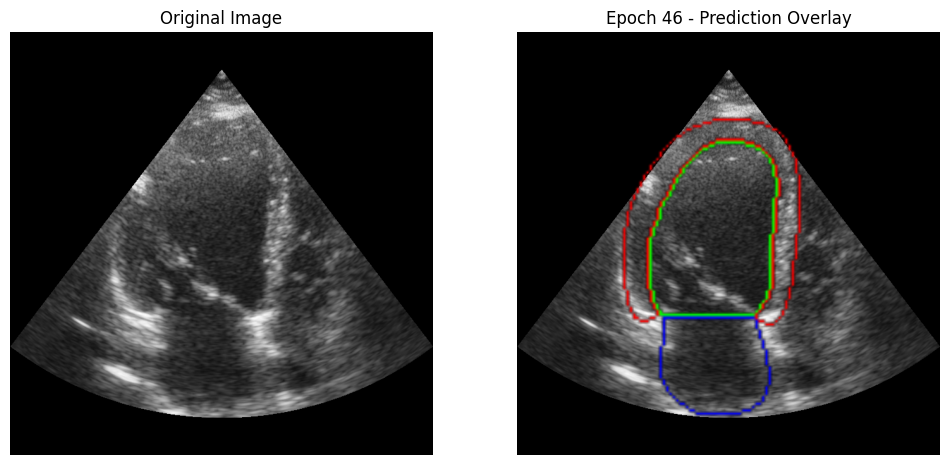

Epoch 47/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.89it/s]


Train Loss: 0.0457, Train Dice: 0.9602
Val Loss: 0.0764, Val Dice: 0.9306
Epoch 48/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.89it/s]


Train Loss: 0.0444, Train Dice: 0.9616
Val Loss: 0.0789, Val Dice: 0.9276
Epoch 49/50


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.74it/s]


Train Loss: 0.0452, Train Dice: 0.9605
Val Loss: 0.0765, Val Dice: 0.9300
Epoch 50/50


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Train Loss: 0.0439, Train Dice: 0.9617
Val Loss: 0.0764, Val Dice: 0.9293
Video saved as predictions_only_video.avi with 25 frames


<Figure size 640x480 with 0 Axes>

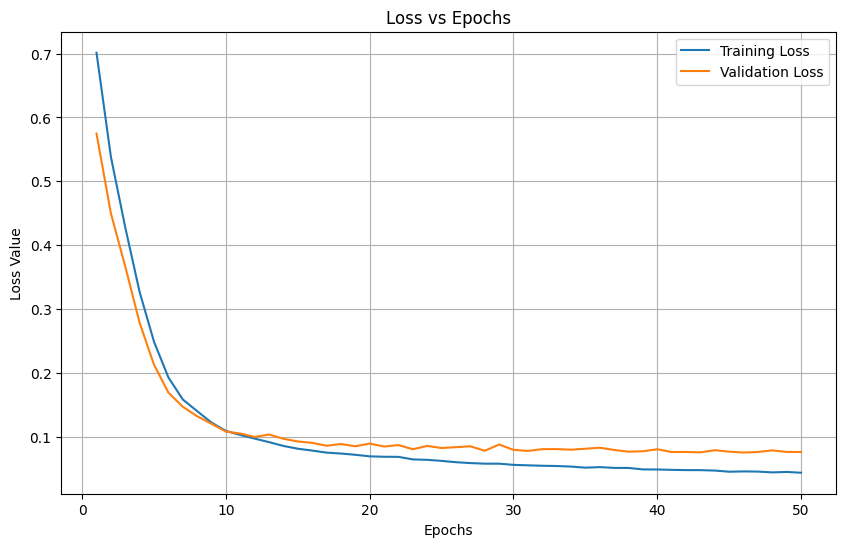

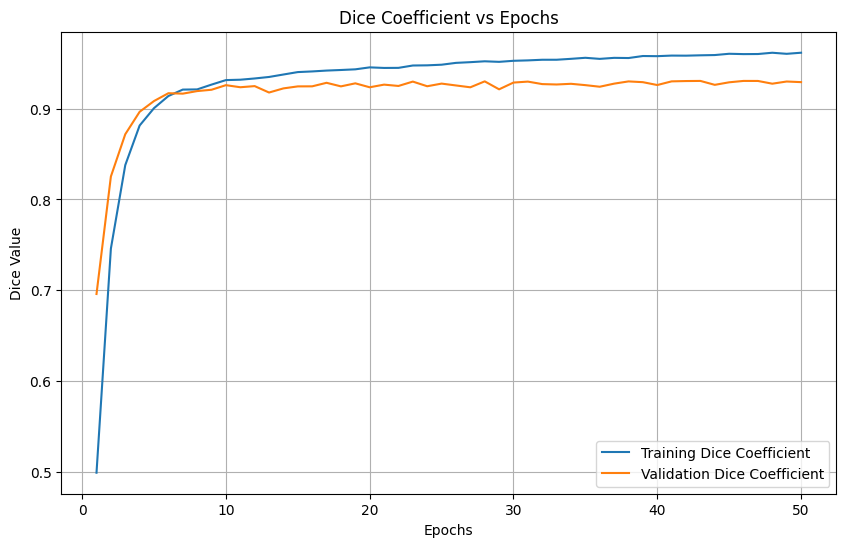

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import torch

# Lists to store metrics
train_losses = []
val_losses = []
train_dices = []
val_dices = []
best_val_loss = float('inf')
patience = 0
prediction_frames = []  # Added to store frames

def plot_metrics(train_metric, val_metric, metric_name, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_metric) + 1), train_metric, label=f'Training {metric_name}')
    plt.plot(range(1, len(val_metric) + 1), val_metric, label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.title(f'{metric_name} vs Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{metric_name.lower()}_plot.png')
    plt.show()
    plt.close()

test_image_idx = 0

def colorize_mask(mask, class_colors):
    """Convert a mask to RGBA using the defined colormap with transparent background."""
    mask_rgba = np.zeros((*mask.shape, 4), dtype=np.uint8)

    process_order = [1, 2, 3]
    for c in process_order:
        if c not in class_colors:
            continue

        binary_mask = (mask == c).astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        color = class_colors[c]
        cv2.drawContours(mask_rgba, contours, -1, (*color, 255), 1)

    return mask_rgba

# Color scheme
class_colors = {
    1: (0, 255, 0),  # green
    2: (0, 0, 255),  # blue
    3: (255, 0, 0)   # red
}

def visualize_prediction_and_show(model, dataset, idx, epoch, device, class_colors):
    model.eval()
    original_image_path = os.path.join(test_images_path, test_dataset.images[idx])
    original_image = cv2.imread(original_image_path)
    image, _,_ = dataset[idx]

    image_batch = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_batch)
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Get RGBA prediction mask
    pred_rgba = colorize_mask(pred, class_colors)
    pred_rgba_resized = cv2.resize(pred_rgba, (original_image.shape[1], original_image.shape[0]))

    # Convert original image to RGBA
    original_rgba = cv2.cvtColor(original_image, cv2.COLOR_BGR2BGRA)

    # Blend images
    foreground = pred_rgba_resized.astype(float) / 255
    background = original_rgba.astype(float) / 255

    # Use alpha channel for blending
    alpha = foreground[:, :, 3:4]
    result = foreground[:, :, :3] * alpha + background[:, :, :3] * (1 - alpha)
    result = (result * 255).astype(np.uint8)

    # Display the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title(f"Epoch {epoch+1} - Prediction Overlay")
    plt.axis('off')

    plt.show(block=False)
    plt.pause(0.1)
    plt.clf()

    # Add epoch number to the frame
    result_bgr = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = f'Epoch: {epoch+1}'
    # Add white background to text for better visibility
    text_size = cv2.getTextSize(text, font, 1, 2)[0]
    text_x = 10
    text_y = 30
    cv2.rectangle(result_bgr,
                 (text_x - 5, text_y - text_size[1] - 5),
                 (text_x + text_size[0] + 5, text_y + 5),
                 (255, 255, 255),
                 -1)
    # Add black text
    cv2.putText(result_bgr,
                text,
                (text_x, text_y),
                font,
                1,
                (0, 0, 0),
                2,
                cv2.LINE_AA)

    # Store the frame for later video creation
    prediction_frames.append(result_bgr)

# Training loop
for epoch in range(NBEPOCHS):
    print(f"Epoch {epoch+1}/{NBEPOCHS}")

    train_loss, train_iou = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_iou = validate(model, valid_loader, criterion, device)

    train_dice = 2 * train_iou / (1 + train_iou)
    val_dice = 2 * val_iou / (1 + val_iou)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_dices.append(train_dice)
    val_dices.append(val_dice)

    print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
        torch.save(model.state_dict(), os.path.join(model_path, "best_model.pth"))
        print("Model saved!")

        model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth")))
        visualize_prediction_and_show(model, test_dataset, test_image_idx, epoch, device, class_colors)
    else:
        patience += 1
        if patience >= NBPATIENCE_EPOCHS:
            print("Early stopping triggered!")
            break

# Create video after training
if prediction_frames:
    # Get dimensions from the first frame
    height, width = prediction_frames[0].shape[:2]
    video_filename = "predictions_only_video.avi"
    video_writer = cv2.VideoWriter(video_filename,
                                 cv2.VideoWriter_fourcc(*'XVID'),
                                 2,  # fps
                                 (width, height),
                                 isColor=True)

    # Write all stored frames to video
    for frame in prediction_frames:
        video_writer.write(frame)

    video_writer.release()
    print(f"Video saved as {video_filename} with {len(prediction_frames)} frames")

# Plot final metrics
plot_metrics(train_losses, val_losses, 'Loss', 'Loss Value')
plot_metrics(train_dices, val_dices, 'Dice Coefficient', 'Dice Value')

# Separate datasets for ED and ES frames


In [ ]:
# Separate datasets for ED and ES frames
ed_images = []
es_images = []

# Filter test dataset based on image name
for image, mask, filename in test_dataset:
    # print("Image name: ", filename)
    if filename.endswith("ED.png"):
        # print("Image name ED: ", filename)
        ed_images.append((image, mask))
    elif filename.endswith("ES.png"):
        # print("Image name ES: ", filename)
        es_images.append((image, mask))

# Create DataLoaders for ED and ES frames
ed_loader = DataLoader(ed_images, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
es_loader = DataLoader(es_images, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Evaluation


## Built-in functions

### Test on the whole images

In [ ]:
import torch
import numpy as np
from torchmetrics import Dice, JaccardIndex, F1Score
from medpy.metric.binary import hd, assd
from sklearn.metrics import f1_score
from monai.metrics import HausdorffDistanceMetric, SurfaceDistanceMetric

# Number of classes (excluding background class)
NUM_CLASSES = 4  # Assuming classes 1, 2, 3, ..., NUM_CLASSES - 1 are non-background classes
BACKGROUND_CLASS = 0  # Background class index

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the best model weights
model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=device))
model.eval()

# Function to compute IoU (Intersection over Union)
def compute_iou(pred, target):
    intersection = (pred * target).sum()
    union = (pred + target).clip(0, 1).sum()
    iou = intersection / (union + 1e-6)
    return iou

# Initialize metrics with ignore_index to exclude the background class
dice_metric = Dice(average="macro", num_classes=NUM_CLASSES, ignore_index=BACKGROUND_CLASS).to(device)
iou_metric = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES, ignore_index=BACKGROUND_CLASS).to(device)
f1_metric = F1Score(task="multiclass", num_classes=NUM_CLASSES, ignore_index=BACKGROUND_CLASS).to(device)
hd_metric = HausdorffDistanceMetric(include_background=False, percentile=95)
assd_metric = SurfaceDistanceMetric(include_background=False)

# Metric Containers
dice_scores = []
iou_scores = []
f1_scores = []
hd_scores = []
assd_scores = []

# Per-class metric
per_class_dice_scores = [[] for _ in range(NUM_CLASSES)]
per_class_iou_scores = [[] for _ in range(NUM_CLASSES)]
per_class_hd_scores = [[] for _ in range(NUM_CLASSES)]
per_class_assd_scores = [[] for _ in range(NUM_CLASSES)]
per_class_f1_scores = [[] for _ in range(NUM_CLASSES)]

# Test loss
num_batches = 0
test_loss = 0

with torch.no_grad():
    for images, masks, _ in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        loss = criterion(outputs, masks)
        test_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)

        # Compute overall metrics
        dice_value = dice_metric(preds, masks)
        iou_value = iou_metric(preds, masks)
        f1_value = f1_metric(preds, masks)

        dice_scores.append(dice_value.item())
        iou_scores.append(iou_value.item())
        f1_scores.append(f1_value.item())

        # Compute per-class metrics excluding background
        for cls in range(1, NUM_CLASSES):
            # Extract binary masks for the current class
            preds_cls = (preds == cls).int()
            masks_cls = (masks == cls).int()

            # Compute Dice score for the current class
            dice_score_cls = dice_metric(preds_cls, masks_cls)
            iou_score_cls = compute_iou(preds_cls.float().cpu().numpy(), masks_cls.float().cpu().numpy())

            per_class_dice_scores[cls].append(dice_score_cls.item())
            per_class_iou_scores[cls].append(iou_score_cls.item())

            preds_cls_np = preds_cls.cpu().numpy()
            masks_cls_np = masks_cls.cpu().numpy()

            # Compute F1 score using scikit-learn
            preds_flat = preds_cls_np.flatten()
            masks_flat = masks_cls_np.flatten()
            f1 = f1_score(masks_flat, preds_flat, average="binary", zero_division=0)
            per_class_f1_scores[cls].append(f1)

            # Compute HD and ASSD (requires numpy arrays)
            for p, m in zip(preds_cls_np, masks_cls_np):
                if p.any() and m.any():  # Avoid computation if no foreground in either
                    per_class_hd_scores[cls].append(hd(p, m))
                    per_class_assd_scores[cls].append(assd(p, m))

        # Compute HD and ASSD metrics for the whole batch
        pred_tensor = preds.unsqueeze(1).float()  # Shape: [batch, 1, H, W]
        masks_tensor = masks.unsqueeze(1).float()  # Shape: [batch, 1, H, W]

        hd_metric(y_pred=pred_tensor, y=masks_tensor)
        assd_metric(y_pred=pred_tensor, y=masks_tensor)

        hd_scores.append(hd_metric.aggregate().item())
        assd_scores.append(assd_metric.aggregate().item())

        # Reset MONAI metrics after each batch
        hd_metric.reset()
        assd_metric.reset()

        num_batches += 1

# Compute loss
test_loss /= num_batches

# Compute Overall Averages
overall_dice = sum(dice_scores) / len(dice_scores)
overall_iou = sum(iou_scores) / len(iou_scores)
overall_f1 = sum(f1_scores) / len(f1_scores)
overall_hd = sum(hd_scores) / len(hd_scores)
overall_assd = sum(assd_scores) / len(assd_scores)


print("\nTest Results:")
print(f"Test Loss: {test_loss:.4f}\n")

# Define class names
class_names = ["Left Ventricle", "Myocardium", "Left Atrium"]

# Prepare results for overall evaluation and per-class evaluation
overall_results = [
    ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
]

per_class_results = []
for c in range(1, NUM_CLASSES):  # Exclude background class
    per_class_results.append([
        class_names[c-1],  # Use class names
        f"{np.mean(per_class_dice_scores[c]):.3f}",
        f"{np.nanmean(per_class_iou_scores[c]):.3f}",
        f"{np.mean(per_class_assd_scores[c]):.2f}",
        f"{np.mean(per_class_hd_scores[c]):.1f}",
        f"{np.mean(per_class_f1_scores[c]):.3f}"
    ])

# Combine overall and per-class results into one table
combined_results = [
    ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
] + per_class_results

# Table headers
headers = ["Class", "Dice", "IoU", "ASSD", "Hausdorff", "F1 Score"]

# Print the combined table with specific formats for each column
print(tabulate(combined_results, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

<ipython-input-36-9b6d0f96f535>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=d


Test Results:
Test Loss: 0.0691

+----------------+--------+-------+--------+-------------+------------+
| Class          |   Dice |   IoU |   ASSD |   Hausdorff |   F1 Score |
+================+========+=======+========+=============+============+
| Overall        |  0.917 | 0.888 |   0.99 |         2.5 |      0.922 |
+----------------+--------+-------+--------+-------------+------------+
| Left Ventricle |  0.945 | 0.896 |   0.95 |         3.1 |      0.945 |
+----------------+--------+-------+--------+-------------+------------+
| Myocardium     |  0.878 | 0.783 |   1.00 |         3.5 |      0.878 |
+----------------+--------+-------+--------+-------------+------------+
| Left Atrium    |  0.929 | 0.868 |   1.04 |         3.5 |      0.929 |
+----------------+--------+-------+--------+-------------+------------+


In [ ]:
import os
import torch
from torchmetrics import Dice, JaccardIndex, F1Score
from monai.metrics import HausdorffDistanceMetric, SurfaceDistanceMetric
from monai.transforms import AsDiscrete

# Constants
NUM_CLASSES = 4  # Total number of classes including background
BACKGROUND_CLASS = 0  # Background class index
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the best model weights
model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=device))
model.eval()

# Initialize metrics with ignore_index to exclude the background class
dice_metric = Dice(average="macro", num_classes=NUM_CLASSES, ignore_index=BACKGROUND_CLASS).to(device)
iou_metric = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES, ignore_index=BACKGROUND_CLASS).to(device)
f1_metric = F1Score(task="multiclass", num_classes=NUM_CLASSES, ignore_index=BACKGROUND_CLASS).to(device)
hd_metric = HausdorffDistanceMetric(include_background=False, percentile=95)
assd_metric = SurfaceDistanceMetric(include_background=False)

# Ensure predictions and masks are in discrete form
post_pred = AsDiscrete(argmax=True)  # Convert logits to class labels
post_label = AsDiscrete(to_onehot=NUM_CLASSES)  # Convert masks to one-hot encoding

# Metric Containers
dice_scores = []
iou_scores = []
f1_scores = []
hd_scores = []
assd_scores = []
hd_per_class = []
assd_per_class = []


# Per-class metric containers
per_class_dice_scores = [[] for _ in range(NUM_CLASSES)]
per_class_iou_scores = [[] for _ in range(NUM_CLASSES)]
per_class_f1_scores = [[] for _ in range(NUM_CLASSES)]
per_class_hd_scores = [[] for _ in range(NUM_CLASSES)]
per_class_assd_scores = [[] for _ in range(NUM_CLASSES)]

# Test loss
num_batches = 0
test_loss = 0.0

# Inference Loop
with torch.no_grad():
    for images, masks, _ in test_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        loss = criterion(outputs, masks)
        test_loss += loss.item()

        # Compute overall metrics
        dice_score = dice_metric(preds, masks)
        iou_score = iou_metric(preds, masks)
        f1_score = f1_metric(preds, masks)

        dice_scores.append(dice_score.item())
        iou_scores.append(iou_score.item())
        f1_scores.append(f1_score.item())

        # Compute per-class metrics
        for cls in range(1, NUM_CLASSES):
            # Create binary masks for each class
            pred_cls_mask = (preds == cls).float().unsqueeze(1)  # Shape: [batch, 1, H, W]
            true_cls_mask = (masks == cls).float().unsqueeze(1)  # Shape: [batch, 1, H, W]

            # Compute per-class metrics
            per_class_dice = torch.sum(2 * pred_cls_mask * true_cls_mask) / (torch.sum(pred_cls_mask) + torch.sum(true_cls_mask))
            per_class_iou = torch.sum(pred_cls_mask * true_cls_mask) / torch.sum((pred_cls_mask + true_cls_mask) > 0)
            per_class_f1 = 2 * torch.sum(pred_cls_mask * true_cls_mask) / (torch.sum(pred_cls_mask) + torch.sum(true_cls_mask))

            # per_class_hd_metric = HausdorffDistanceMetric(include_background=False, percentile=95)
            # per_class_assd_metric = SurfaceDistanceMetric(include_background=False)

            hd_metric(y_pred=pred_cls_mask, y=true_cls_mask)
            assd_metric(y_pred=pred_cls_mask, y=true_cls_mask)

            per_class_dice_scores[cls].append(per_class_dice.item())
            per_class_iou_scores[cls].append(per_class_iou.item())
            per_class_f1_scores[cls].append(per_class_f1.item())
            per_class_hd_scores[cls].append(hd_metric.aggregate().item())
            per_class_assd_scores[cls].append(assd_metric.aggregate().item())
            hd_per_class.append(hd_metric.aggregate().item())
            assd_per_class.append(assd_metric.aggregate().item())

            # Reset metrics
            hd_metric.reset()
            assd_metric.reset()

        # Compute HD and ASSD metrics for the whole batch
        pred_tensor = preds.unsqueeze(1).float()  # Shape: [batch, 1, H, W]
        masks_tensor = masks.unsqueeze(1).float()  # Shape: [batch, 1, H, W]

        hd_metric(y_pred=pred_tensor, y=masks_tensor)
        assd_metric(y_pred=pred_tensor, y=masks_tensor)

        hd_scores.append(hd_metric.aggregate().item())
        assd_scores.append(assd_metric.aggregate().item())

        # Reset MONAI metrics after each batch
        hd_metric.reset()
        assd_metric.reset()
        num_batches += 1

# Compute loss
test_loss /= num_batches

# Compute Overall Averages
overall_dice = sum(dice_scores) / len(dice_scores)
overall_iou = sum(iou_scores) / len(iou_scores)
overall_f1 = sum(f1_scores) / len(f1_scores)
overall_hd = sum(hd_per_class) / len(hd_per_class)
overall_assd = sum(assd_per_class) / len(assd_per_class)

# Compute Per-Class Averages
dice_per_class = [sum(scores) / len(scores) if scores else 0 for scores in per_class_dice_scores]
iou_per_class = [sum(scores) / len(scores) if scores else 0 for scores in per_class_iou_scores]
f1_per_class = [sum(scores) / len(scores) if scores else 0 for scores in per_class_f1_scores]
hd_per_class = [sum(scores) / len(scores) if scores else 0 for scores in per_class_hd_scores]
assd_per_class = [sum(scores) / len(scores) if scores else 0 for scores in per_class_assd_scores]


print("\nTest Results:")
print(f"Test Loss: {test_loss:.4f}\n")

# Define class names
class_names = ["Left Ventricle", "Myocardium", "Left Atrium"]

# Prepare results for overall evaluation and per-class evaluation
overall_results = [
    ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
]

per_class_results = []
for c in range(1, NUM_CLASSES):  # Exclude background class
    per_class_results.append([class_names[c-1],  # Use class names instead of "Class 1", "Class 2", etc.
                              f"{dice_per_class[c]:.3f}",
                              f"{iou_per_class[c]:.3f}",
                              f"{assd_per_class[c]:.2f}",
                              f"{hd_per_class[c]:.1f}",
                              f"{f1_per_class[c]:.3f}"])

# Combine overall and per-class results into one table
combined_results = [
    ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
] + per_class_results

# Table headers
headers = ["Class", "Dice", "IoU", "ASSD", "Hausdorff", "F1 Score"]

# Print the combined table with specific formats for each column
print(tabulate(combined_results, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

<ipython-input-37-8cb517adbc46>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=d


Test Results:
Test Loss: 0.0691

+----------------+--------+-------+--------+-------------+------------+
| Class          |   Dice |   IoU |   ASSD |   Hausdorff |   F1 Score |
+================+========+=======+========+=============+============+
| Overall        |  0.917 | 0.888 |   1.01 |         2.6 |      0.922 |
+----------------+--------+-------+--------+-------------+------------+
| Left Ventricle |  0.945 | 0.896 |   0.99 |         2.5 |      0.945 |
+----------------+--------+-------+--------+-------------+------------+
| Myocardium     |  0.878 | 0.783 |   1.02 |         2.5 |      0.878 |
+----------------+--------+-------+--------+-------------+------------+
| Left Atrium    |  0.929 | 0.868 |   1.03 |         2.9 |      0.929 |
+----------------+--------+-------+--------+-------------+------------+


### Test on ED & ES images separatly

In [ ]:
import torch
import numpy as np
from torchmetrics import Dice, JaccardIndex, F1Score
from medpy.metric.binary import hd, assd
from sklearn.metrics import f1_score
from monai.metrics import HausdorffDistanceMetric, SurfaceDistanceMetric

# Number of classes (excluding background class)
NUM_CLASSES = 4  # Assuming classes 1, 2, 3, ..., NUM_CLASSES - 1 are non-background classes
BACKGROUND_CLASS = 0  # Background class index

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the best model weights
model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=device))
model.eval()

# Function to compute IoU (Intersection over Union)
def compute_iou(pred, target):
    intersection = (pred * target).sum()
    union = (pred + target).clip(0, 1).sum()
    iou = intersection / (union + 1e-6)
    return iou

def evaluate(loader, loader_name):
    print(f"Evaluating {loader_name} frames...\n")

    # Initialize metrics with ignore_index to exclude the background class
    dice_metric = Dice(average="macro", num_classes=NUM_CLASSES, ignore_index=BACKGROUND_CLASS).to(device)
    iou_metric = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES, ignore_index=BACKGROUND_CLASS).to(device)
    f1_metric = F1Score(task="multiclass", num_classes=NUM_CLASSES, ignore_index=BACKGROUND_CLASS).to(device)
    hd_metric = HausdorffDistanceMetric(include_background=False, percentile=95)
    assd_metric = SurfaceDistanceMetric(include_background=False)

    # Metric Containers
    dice_scores = []
    iou_scores = []
    f1_scores = []
    hd_scores = []
    assd_scores = []

    # Per-class metric
    per_class_dice_scores = [[] for _ in range(NUM_CLASSES)]
    per_class_iou_scores = [[] for _ in range(NUM_CLASSES)]
    per_class_hd_scores = [[] for _ in range(NUM_CLASSES)]
    per_class_assd_scores = [[] for _ in range(NUM_CLASSES)]
    per_class_f1_scores = [[] for _ in range(NUM_CLASSES)]

    # Test loss
    num_batches = 0
    test_loss = 0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = criterion(outputs, masks)
            test_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)

            # Compute overall metrics
            dice_value = dice_metric(preds, masks)
            iou_value = iou_metric(preds, masks)
            f1_value = f1_metric(preds, masks)

            dice_scores.append(dice_value.item())
            iou_scores.append(iou_value.item())
            f1_scores.append(f1_value.item())

            # Compute per-class metrics excluding background
            for cls in range(1, NUM_CLASSES):
                # Extract binary masks for the current class
                preds_cls = (preds == cls).int()
                masks_cls = (masks == cls).int()

                # Compute Dice score for the current class
                dice_score_cls = dice_metric(preds_cls, masks_cls)
                iou_score_cls = compute_iou(preds_cls.float().cpu().numpy(), masks_cls.float().cpu().numpy())

                per_class_dice_scores[cls].append(dice_score_cls.item())
                per_class_iou_scores[cls].append(iou_score_cls.item())

                preds_cls_np = preds_cls.cpu().numpy()
                masks_cls_np = masks_cls.cpu().numpy()

                # Compute F1 score using scikit-learn
                preds_flat = preds_cls_np.flatten()
                masks_flat = masks_cls_np.flatten()
                f1 = f1_score(masks_flat, preds_flat, average="binary", zero_division=0)
                per_class_f1_scores[cls].append(f1)

                # Compute HD and ASSD (requires numpy arrays)
                for p, m in zip(preds_cls_np, masks_cls_np):
                    if p.any() and m.any():  # Avoid computation if no foreground in either
                        per_class_hd_scores[cls].append(hd(p, m))
                        per_class_assd_scores[cls].append(assd(p, m))

            # Compute HD and ASSD metrics for the whole batch
            pred_tensor = preds.unsqueeze(1).float()  # Shape: [batch, 1, H, W]
            masks_tensor = masks.unsqueeze(1).float()  # Shape: [batch, 1, H, W]

            hd_metric(y_pred=pred_tensor, y=masks_tensor)
            assd_metric(y_pred=pred_tensor, y=masks_tensor)

            hd_scores.append(hd_metric.aggregate().item())
            assd_scores.append(assd_metric.aggregate().item())

            # Reset MONAI metrics after each batch
            hd_metric.reset()
            assd_metric.reset()

            num_batches += 1

    # Compute loss
    test_loss /= num_batches

    # Compute Overall Averages
    overall_dice = sum(dice_scores) / len(dice_scores)
    overall_iou = sum(iou_scores) / len(iou_scores)
    overall_f1 = sum(f1_scores) / len(f1_scores)
    overall_hd = sum(hd_scores) / len(hd_scores)
    overall_assd = sum(assd_scores) / len(assd_scores)


    print("\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}\n")

    # Define class names
    class_names = ["Left Ventricle", "Myocardium", "Left Atrium"]

    # Prepare results for overall evaluation and per-class evaluation
    overall_results = [
        ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
    ]

    per_class_results = []
    for c in range(1, NUM_CLASSES):  # Exclude background class
        per_class_results.append([
            class_names[c-1],  # Use class names
            f"{np.mean(per_class_dice_scores[c]):.3f}",
            f"{np.nanmean(per_class_iou_scores[c]):.3f}",
            f"{np.mean(per_class_assd_scores[c]):.2f}",
            f"{np.mean(per_class_hd_scores[c]):.1f}",
            f"{np.mean(per_class_f1_scores[c]):.3f}"
        ])

    # Combine overall and per-class results into one table
    combined_results = [
        ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
    ] + per_class_results

    # Table headers
    headers = ["Class", "Dice", "IoU", "ASSD", "Hausdorff", "F1 Score"]

    # Print the combined table with specific formats for each column
    print(tabulate(combined_results, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

# Evaluate ED and ES frames separately
evaluate(ed_loader, "ED")
evaluate(es_loader, "ES")

Evaluating ED frames...



<ipython-input-38-c8e44cd13899>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=d


Test Results:
Test Loss: 0.0685

+----------------+--------+-------+--------+-------------+------------+
| Class          |   Dice |   IoU |   ASSD |   Hausdorff |   F1 Score |
+================+========+=======+========+=============+============+
| Overall        |  0.917 | 0.887 |   0.95 |         2.5 |      0.928 |
+----------------+--------+-------+--------+-------------+------------+
| Left Ventricle |  0.952 | 0.909 |   0.93 |         3.1 |      0.952 |
+----------------+--------+-------+--------+-------------+------------+
| Myocardium     |  0.881 | 0.787 |   0.96 |         3.5 |      0.881 |
+----------------+--------+-------+--------+-------------+------------+
| Left Atrium    |  0.918 | 0.849 |   1.02 |         3.4 |      0.918 |
+----------------+--------+-------+--------+-------------+------------+
Evaluating ES frames...


Test Results:
Test Loss: 0.0710

+----------------+--------+-------+--------+-------------+------------+
| Class          |   Dice |   IoU |   ASSD 

# Visualization of Predictions         


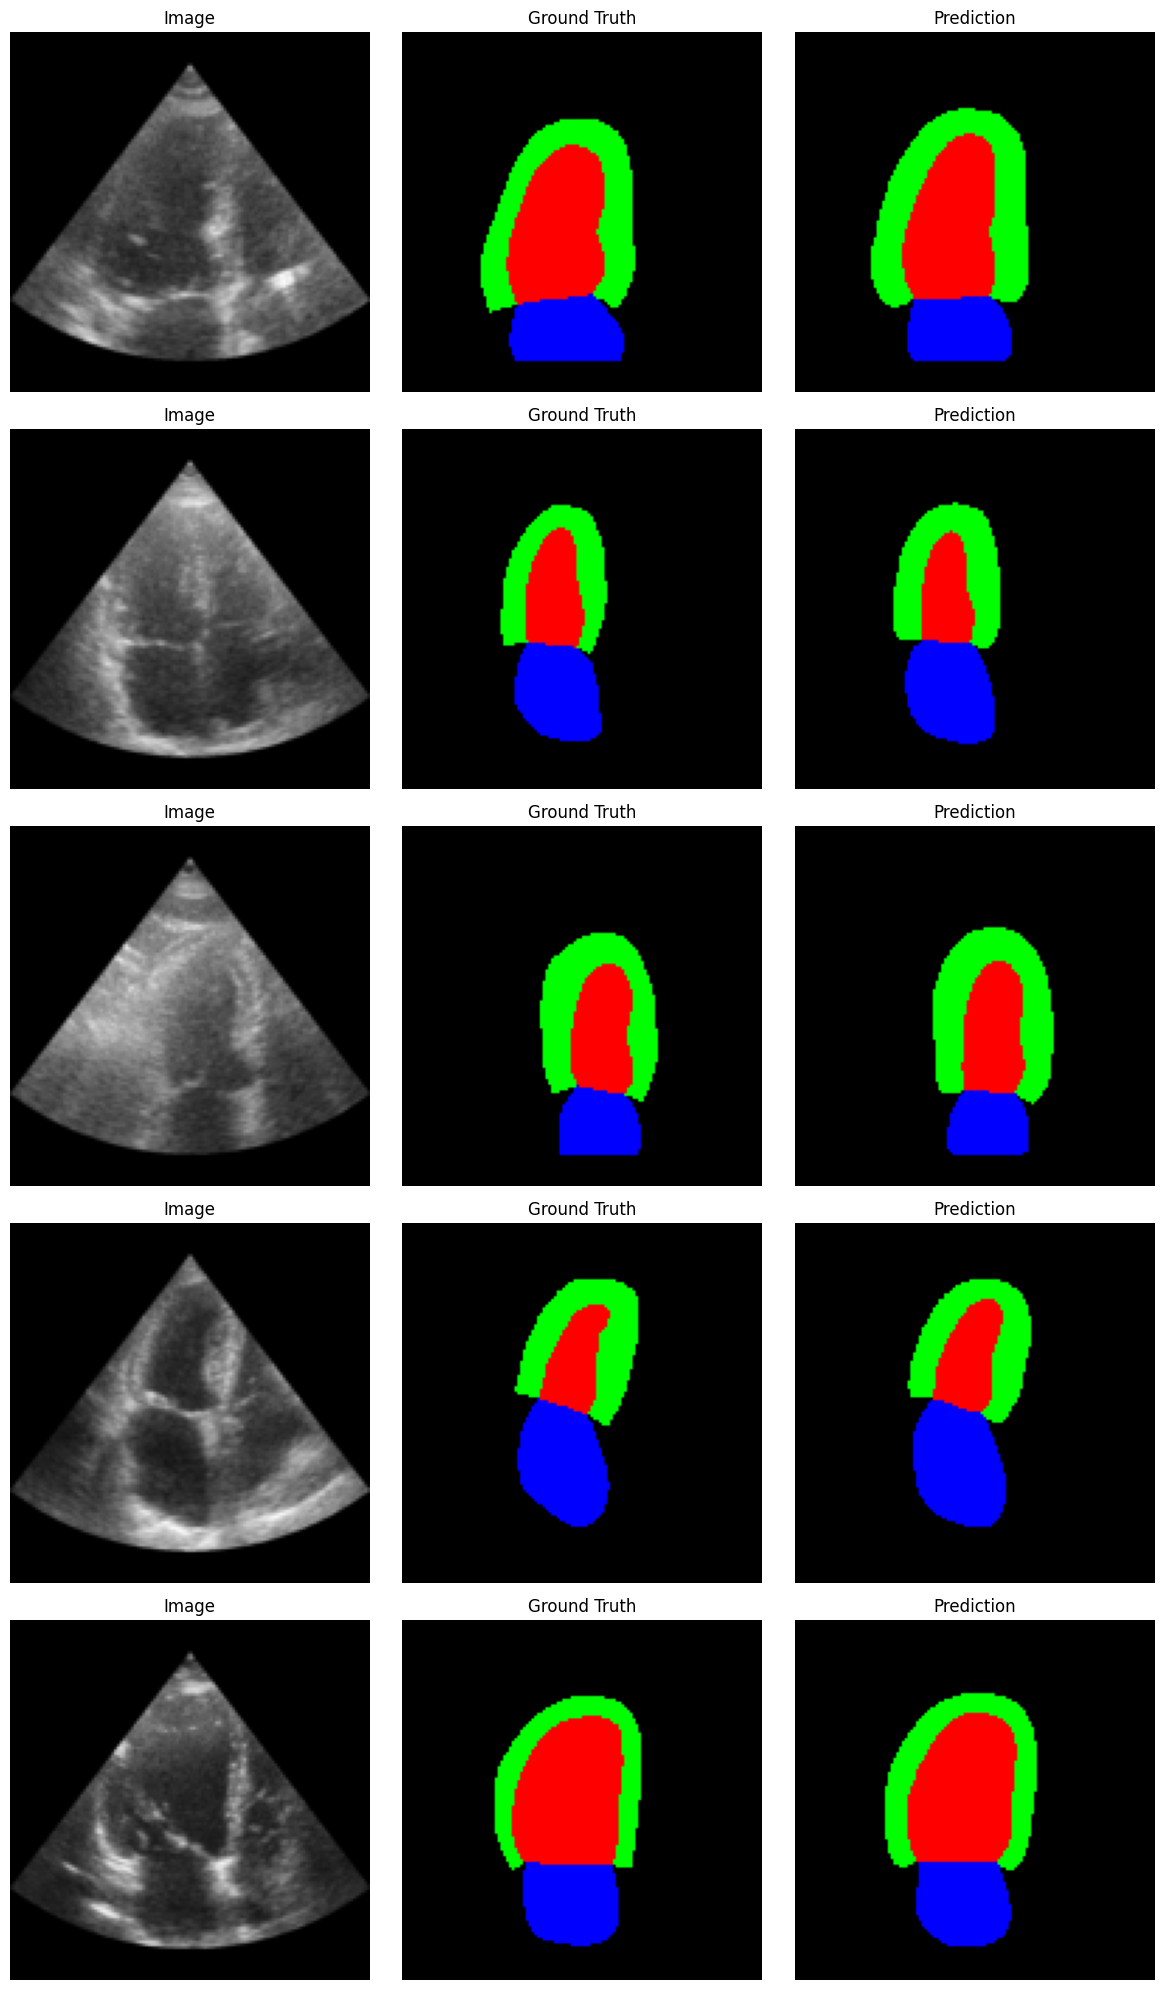

In [ ]:
########################################
# Visualization of Predictions         #
########################################
import matplotlib.pyplot as plt
import random
import numpy as np

# Define a colormap for the classes
class_colors = {
    0: [0, 0, 0],       # Background (black)
    1: [255, 0, 0],     # Class 1 (red)
    2: [0, 255, 0],     # Class 2 (green)
    3: [0, 0, 255],     # Class 3 (blue)
}

def colorize_mask(mask, class_colors):
    """Convert a mask to RGB using the defined colormap."""
    mask_rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for c, color in class_colors.items():
        mask_rgb[mask == c] = color
    return mask_rgb

# Select 5 random images from the test dataset
indices = random.sample(range(len(test_dataset)), 5)

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(12, 20))
model.eval()
for row, idx in enumerate(indices):
    image, mask ,_= test_dataset[idx]
    image_batch = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_batch)
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Convert image back to numpy for visualization
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * 0.5) + 0.5  # De-normalize
    image_np = np.clip(image_np, 0, 1)

    mask_np = mask.squeeze().cpu().numpy()
    pred_np = pred

    # Convert masks to RGB
    mask_rgb = colorize_mask(mask_np, class_colors)
    pred_rgb = colorize_mask(pred_np, class_colors)

    axs[row, 0].imshow(image_np)
    axs[row, 0].set_title("Image")
    axs[row, 0].axis('off')

    axs[row, 1].imshow(mask_rgb)
    axs[row, 1].set_title("Ground Truth")
    axs[row, 1].axis('off')

    axs[row, 2].imshow(pred_rgb)
    axs[row, 2].set_title("Prediction")
    axs[row, 2].axis('off')

plt.tight_layout()
plt.show()


# Draft

## Genral functions


In [ ]:
# Function to compute ASSD for a single class
def compute_assd(pred, target):
    pred_boundary = pred - binary_erosion(pred).astype(float)
    target_boundary = target - binary_erosion(target).astype(float)

    pred_points = np.argwhere(pred_boundary > 0)
    target_points = np.argwhere(target_boundary > 0)

    if len(pred_points) == 0 or len(target_points) == 0:
        return 0  # ASSD is undefined if one of the masks is empty

    distances_pred_to_target = cdist(pred_points, target_points)
    distances_target_to_pred = cdist(target_points, pred_points)

    assd = (np.mean(np.min(distances_pred_to_target, axis=1)) +
            np.mean(np.min(distances_target_to_pred, axis=1))) / 2.0
    return assd

# Function to compute Dice coefficient
def compute_dice(pred, target):
    intersection = (pred * target).sum()
    dice = (2.0 * intersection) / (pred.sum() + target.sum() + 1e-6)
    return dice

# Function to compute IoU (Intersection over Union)
def compute_iou(pred, target):
    intersection = (pred * target).sum()
    union = (pred + target).clip(0, 1).sum()
    iou = intersection / (union + 1e-6)
    return iou

# Function to compute Hausdorff Distance (HD)
def compute_hd(pred, target):
    pred_boundary = pred - binary_erosion(pred).astype(float)
    target_boundary = target - binary_erosion(target).astype(float)

    pred_points = np.argwhere(pred_boundary > 0)
    target_points = np.argwhere(target_boundary > 0)

    if len(pred_points) == 0 or len(target_points) == 0:
        return 0  # HD is undefined if one of the masks is empty

    distances_pred_to_target = cdist(pred_points, target_points)
    distances_target_to_pred = cdist(target_points, pred_points)

    hd_pred_to_target = np.max(np.min(distances_pred_to_target, axis=1))  # max of min distances
    hd_target_to_pred = np.max(np.min(distances_target_to_pred, axis=1))  # max of min distances

    hd = max(hd_pred_to_target, hd_target_to_pred)
    return hd

# Function to compute F1 score
def compute_f1(pred, target):
    tp = (pred * target).sum()  # True positives
    fp = ((pred == 1) & (target == 0)).sum()  # False positives
    fn = ((pred == 0) & (target == 1)).sum()  # False negatives

    if tp + fp + fn == 0:  # Avoid division by zero
        return 0.0

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    return f1

## Simple Average Approach


### Test on the whole images


In [ ]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.spatial.distance import cdist
from tabulate import tabulate

NUM_CLASSES = 4

# Load the best model weights
model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=device))
model.eval()

###################################################################
# Overall & Per Class Evaluation with dice, IOU, ASSD, HD, and F1 #
###################################################################
iou_per_class = [0.0] * (NUM_CLASSES)
dice_per_class = [0.0] * (NUM_CLASSES)
assd_per_class = [0.0] * (NUM_CLASSES)
hd_per_class = [0.0] * (NUM_CLASSES)
f1_per_class = [0.0] * (NUM_CLASSES)
num_samples = 0

# Initialize accumulators for overall metrics
overall_iou = 0.0
overall_dice = 0.0
overall_assd = 0.0
overall_hd = 0.0
overall_f1 = 0.0

# For loss
num_batches = 0
test_loss = 0.0

with torch.no_grad():
    for images, masks,_ in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        loss = criterion(outputs, masks)
        test_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)

        batch_iou = 0.0
        batch_dice = 0.0
        batch_assd = 0.0
        batch_hd = 0.0
        batch_f1 = 0.0

        for i in range(images.size(0)):
            iou_scores = []
            dice_scores = []
            assd_scores = []
            hd_scores = []
            f1_scores = []
            for c in range(1, NUM_CLASSES):  # Exclude background class
                pred_c = (preds[i] == c).float().cpu().numpy()
                target_c = (masks[i] == c).float().cpu().numpy()

                # IoU and Dice
                iou_value = compute_iou(pred_c, target_c)
                iou_scores.append(iou_value)
                iou_per_class[c] += iou_value

                dice_value = compute_dice(pred_c, target_c)
                dice_scores.append(dice_value)
                dice_per_class[c] += dice_value

                # ASSD
                assd_value = compute_assd(pred_c, target_c)
                assd_scores.append(assd_value)
                if assd_value is not None:
                    assd_per_class[c] += assd_value

                # Hausdorff Distance (HD)
                hd_value = compute_hd(pred_c, target_c)
                hd_scores.append(hd_value)
                if hd_value is not None:
                    hd_per_class[c] += hd_value

                # F1 Score
                f1_value = compute_f1(pred_c, target_c)
                f1_scores.append(f1_value)
                f1_per_class[c] += f1_value


            # Compute overall IoU and Dice for this image (excluding background)
            batch_iou += sum(iou_scores) / (NUM_CLASSES - 1)  # Exclude background class
            batch_dice += sum(dice_scores) / (NUM_CLASSES - 1)  # Exclude background class
            batch_assd += sum(assd_scores) / (NUM_CLASSES - 1)  # Exclude background class
            batch_hd += sum(hd_scores) / (NUM_CLASSES - 1)  # Exclude background class
            batch_f1 += sum(f1_scores) / (NUM_CLASSES - 1)  # Exclude background class

            num_samples += 1

        batch_iou /= images.size(0)
        batch_dice /= images.size(0)
        batch_assd /= images.size(0)
        batch_hd /= images.size(0)
        batch_f1 /= images.size(0)

        overall_iou += batch_iou
        overall_dice += batch_dice
        overall_assd += batch_assd
        overall_hd += batch_hd
        overall_f1 += batch_f1
        num_batches += 1

# Compute loss
test_loss /= num_batches

# Compute Overall
overall_iou /= num_batches
overall_dice /= num_batches
overall_assd /= num_batches
overall_hd /= num_batches
overall_f1 /= num_batches

# Normalize metrics per class
iou_per_class = [iou / num_samples for iou in iou_per_class]
dice_per_class = [dice / num_samples for dice in dice_per_class]
assd_per_class = [assd / num_samples for assd in assd_per_class]
hd_per_class = [hd / num_samples for hd in hd_per_class]
f1_per_class = [f1 / num_samples for f1 in f1_per_class]


print("\nTest Results:")
print(f"Test Loss: {test_loss:.4f}\n")

# Define class names
class_names = ["Left Ventricle", "Myocardium", "Left Atrium"]

# Prepare results for overall evaluation and per-class evaluation
overall_results = [
    ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
]

per_class_results = []
for c in range(1, NUM_CLASSES):  # Exclude background class
    per_class_results.append([class_names[c-1],  # Use class names instead of "Class 1", "Class 2", etc.
                              f"{dice_per_class[c]:.3f}",
                              f"{iou_per_class[c]:.3f}",
                              f"{assd_per_class[c]:.2f}",
                              f"{hd_per_class[c]:.1f}",
                              f"{f1_per_class[c]:.3f}"])

# Combine overall and per-class results into one table
combined_results = [
    ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
] + per_class_results

# Table headers
headers = ["Class", "Dice", "IoU", "ASSD", "Hausdorff", "F1 Score"]

# Print the combined table with specific formats for each column
print(tabulate(combined_results, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

<ipython-input-41-93f3761cce8d>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=de


Test Results:
Test Loss: 0.0691

+----------------+--------+-------+--------+-------------+------------+
| Class          |   Dice |   IoU |   ASSD |   Hausdorff |   F1 Score |
+================+========+=======+========+=============+============+
| Overall        |  0.914 | 0.845 |   1.00 |         3.4 |      0.914 |
+----------------+--------+-------+--------+-------------+------------+
| Left Ventricle |  0.942 | 0.891 |   0.95 |         3.1 |      0.942 |
+----------------+--------+-------+--------+-------------+------------+
| Myocardium     |  0.878 | 0.784 |   1.00 |         3.5 |      0.878 |
+----------------+--------+-------+--------+-------------+------------+
| Left Atrium    |  0.925 | 0.864 |   1.02 |         3.5 |      0.925 |
+----------------+--------+-------+--------+-------------+------------+


### Test on ED & ES images separatly


In [ ]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.spatial.distance import cdist
from tabulate import tabulate

NUM_CLASSES = 4

# Load the best model weights
model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=device))
model.eval()

###################################################################
# Overall & Per Class Evaluation with dice, IOU, ASSD, HD, and F1 #
###################################################################
# Function to evaluate a specific DataLoader
def evaluate(loader, loader_name):
    print(f"Evaluating {loader_name} frames...\n")

    iou_per_class = [0.0] * (NUM_CLASSES)
    dice_per_class = [0.0] * (NUM_CLASSES)
    assd_per_class = [0.0] * (NUM_CLASSES)
    hd_per_class = [0.0] * (NUM_CLASSES)
    f1_per_class = [0.0] * (NUM_CLASSES)
    num_samples = 0

    # Initialize accumulators for overall metrics
    overall_iou = 0.0
    overall_dice = 0.0
    overall_assd = 0.0
    overall_hd = 0.0
    overall_f1 = 0.0

    # For loss
    num_batches = 0
    test_loss = 0.0

    with torch.no_grad():
        for images, masks  in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = criterion(outputs, masks)
            test_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)

            batch_iou = 0.0
            batch_dice = 0.0
            batch_assd = 0.0
            batch_hd = 0.0
            batch_f1 = 0.0

            for i in range(images.size(0)):
                iou_scores = []
                dice_scores = []
                assd_scores = []
                hd_scores = []
                f1_scores = []
                for c in range(1, NUM_CLASSES):  # Exclude background class
                    pred_c = (preds[i] == c).float().cpu().numpy()
                    target_c = (masks[i] == c).float().cpu().numpy()

                    # IoU and Dice
                    iou_value = compute_iou(pred_c, target_c)
                    iou_scores.append(iou_value)
                    iou_per_class[c] += iou_value

                    dice_value = compute_dice(pred_c, target_c)
                    dice_scores.append(dice_value)
                    dice_per_class[c] += dice_value

                    # ASSD
                    assd_value = compute_assd(pred_c, target_c)
                    assd_scores.append(assd_value)
                    if assd_value is not None:
                        assd_per_class[c] += assd_value

                    # Hausdorff Distance (HD)
                    hd_value = compute_hd(pred_c, target_c)
                    hd_scores.append(hd_value)
                    if hd_value is not None:
                        hd_per_class[c] += hd_value

                    # F1 Score
                    f1_value = compute_f1(pred_c, target_c)
                    f1_scores.append(f1_value)
                    f1_per_class[c] += f1_value


                # Compute overall IoU and Dice for this image (excluding background)
                batch_iou += sum(iou_scores) / (NUM_CLASSES - 1)  # Exclude background class
                batch_dice += sum(dice_scores) / (NUM_CLASSES - 1)  # Exclude background class
                batch_assd += sum(assd_scores) / (NUM_CLASSES - 1)  # Exclude background class
                batch_hd += sum(hd_scores) / (NUM_CLASSES - 1)  # Exclude background class
                batch_f1 += sum(f1_scores) / (NUM_CLASSES - 1)  # Exclude background class

                num_samples += 1

            batch_iou /= images.size(0)
            batch_dice /= images.size(0)
            batch_assd /= images.size(0)
            batch_hd /= images.size(0)
            batch_f1 /= images.size(0)

            overall_iou += batch_iou
            overall_dice += batch_dice
            overall_assd += batch_assd
            overall_hd += batch_hd
            overall_f1 += batch_f1
            num_batches += 1

    # Compute loss
    test_loss /= num_batches

    # Compute Overall
    overall_iou /= num_batches
    overall_dice /= num_batches
    overall_assd /= num_batches
    overall_hd /= num_batches
    overall_f1 /= num_batches

    # Normalize metrics per class
    iou_per_class = [iou / num_samples for iou in iou_per_class]
    dice_per_class = [dice / num_samples for dice in dice_per_class]
    assd_per_class = [assd / num_samples for assd in assd_per_class]
    hd_per_class = [hd / num_samples for hd in hd_per_class]
    f1_per_class = [f1 / num_samples for f1 in f1_per_class]


    print("\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}\n")

    # Define class names
    class_names = ["Left Ventricle", "Myocardium", "Left Atrium"]

    # Prepare results for overall evaluation and per-class evaluation
    overall_results = [
        ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
    ]

    per_class_results = []
    for c in range(1, NUM_CLASSES):  # Exclude background class
        per_class_results.append([class_names[c-1],  # Use class names instead of "Class 1", "Class 2", etc.
                                f"{dice_per_class[c]:.3f}",
                                f"{iou_per_class[c]:.3f}",
                                f"{assd_per_class[c]:.2f}",
                                f"{hd_per_class[c]:.1f}",
                                f"{f1_per_class[c]:.3f}"])

    # Combine overall and per-class results into one table
    combined_results = [
        ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
    ] + per_class_results

    # Table headers
    headers = ["Class", "Dice", "IoU", "ASSD", "Hausdorff", "F1 Score"]

    # Print the combined table with specific formats for each column
    print(tabulate(combined_results, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

# Evaluate ED and ES frames separately
evaluate(ed_loader, "ED")
evaluate(es_loader, "ES")

Evaluating ED frames...



<ipython-input-42-8b13540edad7>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=de


Test Results:
Test Loss: 0.0685

+----------------+--------+-------+--------+-------------+------------+
| Class          |   Dice |   IoU |   ASSD |   Hausdorff |   F1 Score |
+================+========+=======+========+=============+============+
| Overall        |  0.915 | 0.846 |   0.96 |         3.5 |      0.915 |
+----------------+--------+-------+--------+-------------+------------+
| Left Ventricle |  0.951 | 0.908 |   0.93 |         3.1 |      0.951 |
+----------------+--------+-------+--------+-------------+------------+
| Myocardium     |  0.877 | 0.783 |   0.96 |         3.5 |      0.877 |
+----------------+--------+-------+--------+-------------+------------+
| Left Atrium    |  0.917 | 0.852 |   1.01 |         3.4 |      0.917 |
+----------------+--------+-------+--------+-------------+------------+
Evaluating ES frames...


Test Results:
Test Loss: 0.0710

+----------------+--------+-------+--------+-------------+------------+
| Class          |   Dice |   IoU |   ASSD 

## Weighted Average Approach

### Test on the whole images


In [ ]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.spatial.distance import cdist
from tabulate import tabulate

NUM_CLASSES = 4

# Load the best model weights
model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=device))
model.eval()

###################################################################
# Overall & Per Class Evaluation with dice, IOU, ASSD, HD, and F1 #
###################################################################
iou_per_class = [0.0] * (NUM_CLASSES)
dice_per_class = [0.0] * (NUM_CLASSES)
assd_per_class = [0.0] * (NUM_CLASSES)
hd_per_class = [0.0] * (NUM_CLASSES)
f1_per_class = [0.0] * (NUM_CLASSES)
num_samples = 0

# Initialize accumulators for overall metrics
overall_iou = 0.0
overall_dice = 0.0
overall_assd = 0.0
overall_hd = 0.0
overall_f1 = 0.0
class_weights = [0.0] * (NUM_CLASSES)  # To calculate class-specific weights

# For Test loss
num_batches = 0
test_loss = 0.0

with torch.no_grad():
    for images, masks,_ in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        loss = criterion(outputs, masks)
        test_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)

        for i in range(images.size(0)):
            for c in range(1, NUM_CLASSES):  # Exclude background class
                pred_c = (preds[i] == c).float().cpu().numpy()
                target_c = (masks[i] == c).float().cpu().numpy()

                # IoU and Dice
                iou_value = compute_iou(pred_c, target_c)
                iou_per_class[c] += iou_value

                dice_value = compute_dice(pred_c, target_c)
                dice_per_class[c] += dice_value

                # ASSD
                assd_value = compute_assd(pred_c, target_c)
                if assd_value is not None:
                    assd_per_class[c] += assd_value

                # Hausdorff Distance (HD)
                hd_value = compute_hd(pred_c, target_c)
                if hd_value is not None:
                    hd_per_class[c] += hd_value

                # F1 Score
                f1_value = compute_f1(pred_c, target_c)
                f1_per_class[c] += f1_value

                # Update weights for overall metrics
                class_weight = target_c.sum()  # Total pixels in the ground truth for class c
                class_weights[c] += class_weight
                overall_iou += (iou_value) * class_weight
                overall_dice += (dice_value) * class_weight
                if assd_value is not None:
                    overall_assd += assd_value * class_weight
                if hd_value is not None:
                    overall_hd += hd_value * class_weight
                overall_f1 += f1_value * class_weight

            num_samples += 1

        num_batches += 1

# Compute loss
test_loss /= num_batches

# Normalize metrics per class
iou_per_class = [iou / num_samples for iou in iou_per_class]
dice_per_class = [dice / num_samples for dice in dice_per_class]
assd_per_class = [assd / num_samples for assd in assd_per_class]
hd_per_class = [hd / num_samples for hd in hd_per_class]
f1_per_class = [f1 / num_samples for f1 in f1_per_class]

# Compute overall metrics by weighted average
total_weight = sum(class_weights[1:])  # Exclude background class weight
overall_iou /= total_weight
overall_dice /= total_weight
overall_assd /= total_weight
overall_hd /= total_weight
overall_f1 /= total_weight


print("\nTest Results:")
print(f"Test Loss: {test_loss:.4f}\n")

# Define class names
class_names = ["Left Ventricle", "Myocardium", "Left Atrium"]

# Prepare results for overall evaluation and per-class evaluation
overall_results = [
    ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
]

per_class_results = []
for c in range(1, NUM_CLASSES):  # Exclude background class
    per_class_results.append([class_names[c-1],  # Use class names instead of "Class 1", "Class 2", etc.
                              f"{dice_per_class[c]:.3f}",
                              f"{iou_per_class[c]:.3f}",
                              f"{assd_per_class[c]:.2f}",
                              f"{hd_per_class[c]:.1f}",
                              f"{f1_per_class[c]:.3f}"])

# Combine overall and per-class results into one table
combined_results = [
    ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
] + per_class_results

# Table headers
headers = ["Class", "Dice", "IoU", "ASSD", "Hausdorff", "F1 Score"]

# Print the combined table with specific formats for each column
print(tabulate(combined_results, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

<ipython-input-43-8062ce294e85>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=de


Test Results:
Test Loss: 0.0691

+----------------+--------+-------+--------+-------------+------------+
| Class          |   Dice |   IoU |   ASSD |   Hausdorff |   F1 Score |
+================+========+=======+========+=============+============+
| Overall        |  0.916 | 0.848 |   1.02 |         3.5 |      0.916 |
+----------------+--------+-------+--------+-------------+------------+
| Left Ventricle |  0.942 | 0.891 |   0.95 |         3.1 |      0.942 |
+----------------+--------+-------+--------+-------------+------------+
| Myocardium     |  0.878 | 0.784 |   1.00 |         3.5 |      0.878 |
+----------------+--------+-------+--------+-------------+------------+
| Left Atrium    |  0.925 | 0.864 |   1.02 |         3.5 |      0.925 |
+----------------+--------+-------+--------+-------------+------------+


### Test on ED & ES images separatly


In [ ]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.spatial.distance import cdist
from tabulate import tabulate

NUM_CLASSES = 4

# Load the best model weights
model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=device))
model.eval()

###################################################################
# Overall & Per Class Evaluation with dice, IOU, ASSD, HD, and F1 #
###################################################################

# Function to evaluate a specific DataLoader
def evaluate(loader, loader_name):
    print(f"Evaluating {loader_name} frames...\n")
    iou_per_class = [0.0] * (NUM_CLASSES)
    dice_per_class = [0.0] * (NUM_CLASSES)
    assd_per_class = [0.0] * (NUM_CLASSES)
    hd_per_class = [0.0] * (NUM_CLASSES)
    f1_per_class = [0.0] * (NUM_CLASSES)
    num_samples = 0

    # Initialize accumulators for overall metrics
    overall_iou = 0.0
    overall_dice = 0.0
    overall_assd = 0.0
    overall_hd = 0.0
    overall_f1 = 0.0
    class_weights = [0.0] * (NUM_CLASSES)  # To calculate class-specific weights

    # For Test loss
    num_batches = 0
    test_loss = 0.0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = criterion(outputs, masks)
            test_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                for c in range(1, NUM_CLASSES):  # Exclude background class
                    pred_c = (preds[i] == c).float().cpu().numpy()
                    target_c = (masks[i] == c).float().cpu().numpy()

                    # IoU and Dice
                    iou_value = compute_iou(pred_c, target_c)
                    iou_per_class[c] += iou_value

                    dice_value = compute_dice(pred_c, target_c)
                    dice_per_class[c] += dice_value

                    # ASSD
                    assd_value = compute_assd(pred_c, target_c)
                    if assd_value is not None:
                        assd_per_class[c] += assd_value

                    # Hausdorff Distance (HD)
                    hd_value = compute_hd(pred_c, target_c)
                    if hd_value is not None:
                        hd_per_class[c] += hd_value

                    # F1 Score
                    f1_value = compute_f1(pred_c, target_c)
                    f1_per_class[c] += f1_value

                    # Update weights for overall metrics
                    class_weight = target_c.sum()  # Total pixels in the ground truth for class c
                    class_weights[c] += class_weight
                    overall_iou += (iou_value) * class_weight
                    overall_dice += (dice_value) * class_weight
                    if assd_value is not None:
                        overall_assd += assd_value * class_weight
                    if hd_value is not None:
                        overall_hd += hd_value * class_weight
                    overall_f1 += f1_value * class_weight

                num_samples += 1

            num_batches += 1

    # Compute loss
    test_loss /= num_batches

    # Normalize metrics per class
    iou_per_class = [iou / num_samples for iou in iou_per_class]
    dice_per_class = [dice / num_samples for dice in dice_per_class]
    assd_per_class = [assd / num_samples for assd in assd_per_class]
    hd_per_class = [hd / num_samples for hd in hd_per_class]
    f1_per_class = [f1 / num_samples for f1 in f1_per_class]

    # Compute overall metrics by weighted average
    total_weight = sum(class_weights[1:])  # Exclude background class weight
    overall_iou /= total_weight
    overall_dice /= total_weight
    overall_assd /= total_weight
    overall_hd /= total_weight
    overall_f1 /= total_weight


    print("\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}\n")

    # Define class names
    class_names = ["Left Ventricle", "Myocardium", "Left Atrium"]

    # Prepare results for overall evaluation and per-class evaluation
    overall_results = [
        ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
    ]

    per_class_results = []
    for c in range(1, NUM_CLASSES):  # Exclude background class
        per_class_results.append([class_names[c-1],  # Use class names instead of "Class 1", "Class 2", etc.
                                f"{dice_per_class[c]:.3f}",
                                f"{iou_per_class[c]:.3f}",
                                f"{assd_per_class[c]:.2f}",
                                f"{hd_per_class[c]:.1f}",
                                f"{f1_per_class[c]:.3f}"])

    # Combine overall and per-class results into one table
    combined_results = [
        ["Overall", f"{overall_dice:.3f}", f"{overall_iou:.3f}", f"{overall_assd:.2f}", f"{overall_hd:.1f}", f"{overall_f1:.3f}"]
    ] + per_class_results

    # Table headers
    headers = ["Class", "Dice", "IoU", "ASSD", "Hausdorff", "F1 Score"]

    # Print the combined table with specific formats for each column
    print(tabulate(combined_results, headers=headers, tablefmt="grid", floatfmt=(".3f", ".3f", ".3f", ".2f", ".1f", ".3f")))

# Evaluate ED and ES frames separately
evaluate(ed_loader, "ED")
evaluate(es_loader, "ES")

<ipython-input-97-abcc296ae0f5>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=de

Evaluating ED frames...


Test Results:
Test Loss: 0.5011

+----------------+--------+-------+--------+-------------+------------+
| Class          |   Dice |   IoU |   ASSD |   Hausdorff |   F1 Score |
+================+========+=======+========+=============+============+
| Overall        |  0.706 | 0.597 |   5.01 |        45.9 |      0.706 |
+----------------+--------+-------+--------+-------------+------------+
| Left Ventricle |  0.912 | 0.839 |   1.80 |        28.8 |      0.912 |
+----------------+--------+-------+--------+-------------+------------+
| Myocardium     |  0.372 | 0.232 |   9.57 |        61.1 |      0.372 |
+----------------+--------+-------+--------+-------------+------------+
| Left Atrium    |  0.795 | 0.670 |   4.30 |        59.9 |      0.795 |
+----------------+--------+-------+--------+-------------+------------+
Evaluating ES frames...


Test Results:
Test Loss: 0.5106

+----------------+--------+-------+--------+-------------+------------+
| Class          |